In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from typing import Tuple, Union, List
import time

In [2]:
import matplotlib.pyplot as plt

# CONFIG

In [3]:
class CONFIG:
    epochs = 50
    n_class = 3
    dont_waste_runtime  = True

### Lensformer (LAST YEAR'S WORK)

**Overview:**
Lensformer utilized the Vision Transformer (ViT) for processing a small dataset. This project served as a baseline for further comparisons and improvements.


## Shifted Patch Tokenizer

The Shifted Patch Tokenizer is designed to divide an image into multiple patches and create embeddings for each patch. 

**Updates:**
- Added a new translation mode that supports both rectangular and diagonal translation.


In [4]:
class ShiftPatchTokenizer(nn.Module):
    def __init__(self, image_size, embedding_size, patch_size, num_channels, translation_mode, device='cpu'):
        super(ShiftPatchTokenizer, self).__init__()

        self.image_size = image_size
        self.embedding_size = embedding_size  # size of the features of each patch
        self.patch_size = patch_size
        self.num_channels = num_channels
        self.translation_mode = translation_mode
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        if self.image_size % self.patch_size != 0:
            raise ValueError("The image size must be divisible by the patch size")
        
        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.num_translations = 4
        self.total_channels = self.num_channels * (1 + self.num_translations)

        self.tokenizer = nn.Conv2d(in_channels=self.total_channels,
                                   out_channels=self.embedding_size,
                                   kernel_size=(self.patch_size, self.patch_size),
                                   stride=(self.patch_size, self.patch_size))

        self.patch_width, self.patch_height = (patch_size, patch_size)
        self.shift_value_x, self.shift_value_y = (self.patch_width // 2, self.patch_height // 2)

        # This will convert the shape of image from I x I x C to self.num_patch(in square) x embedding_size
        # Now the class embeddings
        self.class_embedding = nn.Parameter(torch.zeros(1, 1, self.embedding_size))

        # Now creating the learnable parameter for the positional encoding
        self.positional = nn.Parameter(torch.zeros(1, self.num_patches + 1, self.embedding_size))

    def translation(self, image, delta_x, delta_y):
        trans_image = F.affine(img=image,
                               angle=0,
                               translate=(delta_x, delta_y),
                               scale=1,
                               shear=0)
        trans_image = trans_image.to(self.device)
        return trans_image
    def get_num_patches(self):
        return self.num_patches
    
    def forward(self, image):
        image = image.to(self.device)
        batch = image.shape[0]

        if self.translation_mode == "diagonal":
            shift_left_up = self.translation(image, -self.shift_value_x, -self.shift_value_y)
            shift_right_up = self.translation(image, self.shift_value_x, -self.shift_value_y)
            shift_left_down = self.translation(image, -self.shift_value_x, self.shift_value_y)
            shift_right_down = self.translation(image, self.shift_value_x, self.shift_value_y)

            # Concatenate the image + all the shifts
            patched_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        elif self.translation_mode == "rectangular":
            shift_down = self.translation(image, 0, self.shift_value_y)
            shift_up = self.translation(image, 0, -self.shift_value_y)
            shift_left = self.translation(image, -self.shift_value_x, 0)
            shift_right = self.translation(image, self.shift_value_x, 0)

            # Concatenate the image + all the shifts
            patched_images = torch.cat((image, shift_down, shift_up, shift_left, shift_right), dim=1)
        
        else:
            raise ValueError("Invalid translation_mode")

        # Projection of the images to get the embeddings of all the patches so we have the shape batch, (height/patch_size), (width/patch_size), embedding_size
        projected_embeddings = self.tokenizer(patched_images)
        #print(projected_embeddings.shape)
        patches = projected_embeddings.flatten(2).transpose(1, 2)

        # The new shape of patches is batch, num_patches, embedding_size
        patches = patches.to(self.device)
        
        # Concatenating the class embeddings
        #print(patches.shape)
        class_tokens = self.class_embedding.expand(batch, -1, -1)
        patches = torch.cat((class_tokens, patches), dim=1)

        # Adding the positional encodings
        positional_patches = patches + self.positional

        return positional_patches

In [5]:
"""TESTING THE SHIFTED PATCH TOKENIZER """
tokenizer = ShiftPatchTokenizer(image_size=64, embedding_size=140, patch_size=32, num_channels=1, translation_mode="rectangular", device="cpu")
input_tensor = torch.randn(64, 1, 64, 64).to("cuda")
output = tokenizer(input_tensor)
print(output.shape)  # Expected output shape: (32, num_patches + 1, embedding_size)

torch.Size([64, 5, 140])


## MultiLocallySelfAttention Block 


In [6]:
class MultiLocallySelfAttention(nn.Module):
    """This is a special form of self attention where the intra self-attention 
    calculation is not calculated and the attention calculation is not done 
    from itself it is done by assigning a large weight for the inter-token
    attention calculation and zero for the attention calculation between 
    the tokens itself for this an attention mask is calculated with False 
    on the diagonal and True on the else where. 
    like this 
       [[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [False, False, False,  True]] 
    """
    def __init__(self, embedding_dim, num_heads, num_patches, device, dropout=0.1):
        super(MultiLocallySelfAttention, self).__init__()  # corrected super() call
        
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.device = device
        self.dropout = dropout
        
        # Initialize the attention mask
        #self.attention_mask = torch.ones(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool)
        #self.attention_mask = self.attention_mask.triu(1) + self.attention_mask.tril(-1)
        #self.attention_mask = self.attention_mask.to(self.device)
        self.attention_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attention_mask = self.attention_mask.to(device)

        # Initializing the multi-head self-attention layer
        self.mha = nn.MultiheadAttention(self.embedding_dim, self.num_heads, dropout=self.dropout, batch_first=True)
        
    def forward(self, key, query, value):
        x, _ = self.mha(query, key, value, attn_mask=self.attention_mask)
        return x


## FeedForwardBlock

In [7]:
class FeedForwardBlock(nn.Module):
    """
    This is a FeedForward block with structure like:
    Linear -> Activation Function -> Dropout -> Linear... (repeated for num_hidden_layers)
    
    This block is designed for regression, binary classification, or multi-class classification tasks.
    """
    def __init__(self,
                 in_dim: int,
                 out_dim: int,
                 hidden_dim: int,
                 num_hidden_layers: int,
                 activation_function: nn.Module,
                 task_type: str,
                 dropout: float = 0.1
                ):
        super(FeedForwardBlock, self).__init__()  # corrected super() call
        
        self.feed_list = nn.ModuleList()
        self.feed_list.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))  # add initial linear layer
        self.feed_list.append(activation_function())  # add activation function
        self.feed_list.append(nn.Dropout(dropout))  # add dropout layer
        
        # add hidden layers
        for _ in range(num_hidden_layers):
            self.feed_list.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
            self.feed_list.append(activation_function())
            self.feed_list.append(nn.Dropout(dropout))
        
        # determine final activation layer based on task type
        if task_type == "regression":
            self.final_activation_layer = nn.Identity()
        elif task_type == "binary":
            if out_dim != 1:
                raise ValueError("For binary classification, out_dim should be 1.")
            self.final_activation_layer = nn.Sigmoid()
        elif task_type == "multiclass":
            self.final_activation_layer = nn.Softmax(dim=1)
        else:
            raise ValueError("Task type should be one of: 'regression', 'binary', 'multiclass'.")

        self.feed_list.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))
        self.feed_list.append(self.final_activation_layer)
        
    def forward(self, x):
        """
        Forward pass through the FeedForwardBlock.
        """
        for layer in self.feed_list:
            x = layer(x)
        return x


In [8]:
class TransformerLSABlock(nn.Module):
    def __init__(self,
                 embedding_dim: int,
                 num_head: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        
        super(TransformerLSABlock, self).__init__()

        self.embedding_dim = embedding_dim
        self.device = device
        self.mlsa = MultiLocallySelfAttention(embedding_dim, num_head, num_patches, device, dropout)
        self.first_norm = nn.LayerNorm(embedding_dim)
        self.feedforward = FeedForwardBlock(in_dim=embedding_dim,
                                            out_dim=embedding_dim,
                                            hidden_dim=num_hidden_neurons,
                                            num_hidden_layers=num_hidden_layers,
                                            activation_function=activation_function,
                                            task_type="regression",
                                            dropout=dropout)
        self.second_norm = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)

        self.temperature = nn.Parameter(torch.ones(1))

        self.batch_size = 64        
        self.query_T = nn.Linear(self.embedding_dim, self.embedding_dim)
        self.value_T = nn.Linear(self.embedding_dim, self.embedding_dim)
        

    def forward(self, key: torch.Tensor, query: Union[torch.Tensor, None] = None, value: Union[torch.Tensor, None] = None) -> torch.Tensor:
        batch_size = key.shape[0]
        key = key.to(self.device)

        if query is None:
            query = self.query_T(key)
            query = (query / self.temperature).to(self.device)
        if value is None:
            value = self.value_T(key)

        value = value + self.mlsa(key, query, value)
        value = self.first_norm(value)
        value = value + self.feedforward(value)
        value = self.second_norm(value)
        value = self.dropout(value)
        
        return value


In [9]:
""" TESTING THE TRANSFORMER BLOCK """
transformer = TransformerLSABlock(embedding_dim = 384
                                  ,num_head = 8
                                  ,num_patches = 196,
                                  num_hidden_neurons=64,
                                  num_hidden_layers=1,
                                  activation_function=nn.ReLU,
                                  device="cpu")
print(transformer(torch.randn(100,197,384)).shape)

torch.Size([100, 197, 384])


## Physics Block

The Physics Block implements the lensing inversion process, which uses gravitational lensing equations to transform an observed lensing image into the source image.

**Key Steps:**
1. **Coordinate Transformation:**
   - Transforms normal coordinates/indices to angular coordinates.
   
2. **Lensing Inversion:**
   - Utilizes gravitational lensing equations.
   - Takes the observed lensing image and returns the source image.

**Challenges and Solutions:**
- Some source coordinates fall outside the image size (64 x 64 grid).Solution: Increase the source image grid size and
- Some source coordinates overlap.Solution: Took the average of the intensities for overlapping coordinates.

In [10]:
class Physics():
    def __init__(self,mag = 1,min_angle = -3.232,max_angle = 3.232):
        self.source_mag = mag
        self.min_angle = min_angle
        self.max_angle = max_angle
        
    #def sersic_fit(self,reconstructed_source):
         
    def image_to_source(self,image,centre = None,E_r = None,deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle-self.min_angle)/length
        if centre is None:
            centre = (length//2,width//2)
        centre_x = centre[0]
        centre_y = centre[1]

        range_indices_x = np.arange(-(centre_x-1),length-(centre_x-1))
        range_indices_y = np.arange(-(centre_y-1),width-(centre_y-1))

        x, y = np.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x,y = x*pixel_width,y*pixel_width
        
        r = np.sqrt(x**2 + y**2)
        mask = (r==0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            #gradient = gradient*r
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = np.ones((length,width))*E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef
        
        bx,by = bx/pixel_width,by/pixel_width
        
        bx = np.clip(bx + centre_x*self.source_mag, 0, length*self.source_mag - 1).astype(int)
        by = np.clip(by + centre_y*self.source_mag, 0, width*self.source_mag - 1).astype(int)
        
        sourceimage = np.zeros((length*self.source_mag,width*self.source_mag), dtype=float)
        counts = np.zeros_like(sourceimage, dtype=int)

        for i in range(length):
            for j in range(width):
                sourceimage[bx[i, j], by[i, j]] += image[i, j]
                counts[bx[i, j], by[i, j]] += 1

        average_mask = counts > 0
        sourceimage[average_mask] /= counts[average_mask]
        
        return sourceimage



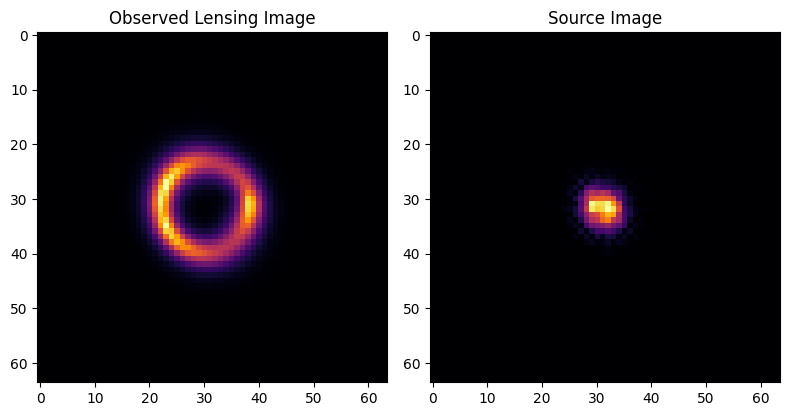

In [11]:
image = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/axion/axion_sim_100000344109220308579478752698140600138.npy", allow_pickle=True)[0]
phy = Physics()
source = phy.image_to_source(image, E_r=1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(image, cmap="inferno")
axs[0].set_title("Observed Lensing Image")
axs[1].imshow(source, cmap="inferno")
axs[1].set_title("Source Image")
plt.tight_layout()
plt.show()


## Encoder block

In [12]:
class PhysicsInformedEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embedding_dim, num_patches, num_heads,
                 hidden_dim, transformer_block_activation_function, num_transformer_block,
                 device: torch.device, k_max, k_min, num_hidden_layer=1, dropout=0.1, pixel_scale=0.101,
                 min_angle=-3.323, max_angle=3.232, mag=1):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.k_max = k_max
        self.k_min = k_min
        self.transformer_block_activation_function = transformer_block_activation_function
        self.num_transformer_block = num_transformer_block
        self.device = device
        self.dropout = dropout
        self.pixel_scale = pixel_scale
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.source_mag = mag

        self.transformer = nn.ModuleList()

        for _ in range(self.num_transformer_block):
            self.transformer.append(
                TransformerLSABlock(embedding_dim=self.embedding_dim,
                                    num_head=self.num_heads,
                                    num_patches=self.num_patches,
                                    num_hidden_neurons=self.hidden_dim,
                                    num_hidden_layers=num_hidden_layer,
                                    activation_function=self.transformer_block_activation_function,
                                    device=self.device,
                                    dropout=dropout)
            )

        # Adding a compressor to give us the deflection angle for each pixel
        self.transformer.append(nn.Flatten())
        self.total_features = (self.num_patches + 1) * self.embedding_dim
        self.transformer.append(nn.Linear(self.total_features, self.image_size*self.image_size))
        self.physics = Physics(mag=1)
        self.imones = torch.ones((self.image_size,self.image_size)).to(self.device)
        self.imones_1d = torch.ones((self.image_size*self.image_size)).to(self.device)
        # Create a grid for image coordinates
        self.profile_size = self.image_size
        self.half_profile_size = self.profile_size // 2

    def image_to_source(self, image, centre=None, E_r=None, deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle - self.min_angle) / length
        if centre is None:
            centre = (length // 2, width // 2)
        centre_x, centre_y = centre
        if False:
            centre_x = centre_x.item()
            centre_y = centre_y.item()
        
        range_indices_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=self.device)
        range_indices_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=self.device)

        x, y = torch.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x, y = x * pixel_width, y * pixel_width

        r = torch.sqrt(x**2 + y**2)
        mask = (r == 0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = torch.ones((length, width), device=self.device) * E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef

        bx, by = bx / pixel_width, by / pixel_width

        bx = torch.clamp(bx + centre_x * self.source_mag, 0, length * self.source_mag - 1).long()
        by = torch.clamp(by + centre_y * self.source_mag, 0, width * self.source_mag - 1).long()

        # Initialize the output image tensor
        sourceimage = torch.zeros((length * self.source_mag, width * self.source_mag), dtype=torch.float, device=self.device)
        
        # Flatten the image and coordinates
        flat_image = image.view(-1)
        flat_bx = bx.view(-1)
        flat_by = by.view(-1)

        # Calculate 1D indices
        one_d_indices = flat_bx * (width * self.source_mag) + flat_by

        # Scatter add the values to sourceimage
        sourceimage_flat = sourceimage.view(-1)
        count  = torch.zeros_like(sourceimage_flat)
        sourceimage_flat = sourceimage_flat.scatter_add(0, one_d_indices, flat_image)
        count = count.scatter_add(0, one_d_indices, self.imones_1d)
        mask = count!=0
        sourceimage_flat[mask]/=count[mask]
        sourceimage = sourceimage_flat.view(sourceimage.shape)

        return sourceimage


    def forward(self, input_images, patches,distortion):
        # Move tensors to the appropriate device
        input_images = input_images.to(self.device)
        distortion = distortion.to(self.device)
        patches = patches.to(self.device)

        batch_size = input_images.shape[0]

        # Process patches through transformer layers
        k_sigmoid = patches
        for layer in self.transformer:
            k_sigmoid = layer(k_sigmoid)

        # Extract output components from k_sigmoid
        k_sigmoid = k_sigmoid.view(batch_size,64,64)
        distortion = distortion.view(batch_size,64,64)
        einstein_angle = k_sigmoid*distortion

        # Reshape input images
        input_images = input_images.view(batch_size, self.image_size, self.image_size)

        # Initialize source_image tensor
        source_image = torch.zeros_like(input_images)

        # Transform each image in the batch
        for i in range(batch_size):
            source_image_np = self.image_to_source(image=input_images[i], E_r=einstein_angle[i])
            source_image[i] = source_image_np

        return k_sigmoid,source_image


In [13]:
phy = PhysicsInformedEncoder(image_size=64, 
                             patch_size=32, 
                             embedding_dim = 384, 
                             num_patches = 4, 
                             num_heads=8,
                             hidden_dim=64, 
                             transformer_block_activation_function=nn.ReLU, 
                             num_transformer_block = 2,
                             device = "cuda", 
                             k_max = 1.2, 
                             k_min = 0.8).to("cuda")

In [14]:
tokenizer = ShiftPatchTokenizer(image_size=64, embedding_size=384, patch_size=32, num_channels=1, translation_mode="rectangular", device="cpu")
input_tensor = torch.randn(64, 1, 64, 64)  
output = tokenizer(input_tensor)
print(output.shape)  


torch.Size([64, 5, 384])


In [15]:
start = time.time()
source = phy(input_tensor,output,input_tensor)
end = time.time()
print(end-start)

0.4561789035797119


In [16]:
class Flatten(nn.Module):
    """
    This module flattens the input tensor into a 2D tensor with a fixed
    number of neurons (elements) in the second dimension.

    Args:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Attributes:
        num_neurons_flatten (int): Number of neurons to flatten the input tensor to.

    Returns:
        Flattened tensor with shape `[batch_size, num_neurons_flatten]`.
    """

    def __init__(self, num_neurons_flatten: int):
        # Initialize the superclass
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten the tensor to the specified number of neurons
        return x.contiguous().view(-1, self.num_neurons_flatten)


In [17]:
import timm

In [18]:
class SiameseNet(nn.Module):
    def __init__(self, model_name, n_class, num_hidden_neurons, num_hidden_layers, feedforward_activation, dropout_rate, mode="concatenate",upsample = False):
        super(SiameseNet, self).__init__()
        self.model_name = model_name
        self.model = timm.create_model(self.model_name, pretrained=True)
        self.mode = mode
        self.upsample = upsample
        if upsample:
            self.resize = nn.ModuleList([
                nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1, 1)),
                nn.Conv2d(in_channels=2, out_channels=3, kernel_size=(1, 1)),
                nn.Upsample(size=(224, 224), mode='bilinear', align_corners=False)
            ])
            
        else:
            self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.fc = nn.Linear(512,3)
        

        if self.mode == "concatenate":
            num_feats = 2000
        elif self.mode == "difference":
            num_feats = 1000
        else:
            raise ValueError("Mode must be 'concatenate' or 'difference'")
        
        self.feedforward_layer = FeedForwardBlock(
                in_dim=num_feats,
                out_dim=n_class,
                hidden_dim=num_hidden_neurons,
                num_hidden_layers=num_hidden_layers,
                activation_function=feedforward_activation,
                task_type='multiclass',
                dropout=dropout_rate
            )
        
        
    def forward(self, source, images):
        if self.upsample:
            for layer in self.resize:
                source = layer(source)
                images = layer(images)
        
        source_feats = self.model(source)
        images_feats = self.model(images)
        
        if self.mode == "concatenate":
            final_feats = torch.cat((source_feats, images_feats), dim=1)
        elif self.mode == "difference":
            final_feats = source_feats - images_feats
        
        predictions = self.feedforward_layer(final_feats)
        return predictions


In [19]:
class Lensformer(nn.Module):
    def __init__(self,
                 image_size: int,
                 patch_size: int,
                 embed_dim: int,
                 in_channels: int,
                 num_classes: int,
                 num_heads: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 transformer_activation: nn.Module,
                 feedforward_activation: nn.Module,
                 num_transformer_blocks: int,
                 device: torch.device,
                 dropout_rate: float = 0.1):
        """
        Initializes Lensformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """
        super(Lensformer, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.secondary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.tertiary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.encoder = PhysicsInformedEncoder(image_size=image_size, 
                                              patch_size=patch_size, 
                                              embedding_dim = embed_dim, 
                                              num_patches = self.initial_tokenizer.get_num_patches(), 
                                              num_heads=num_heads,
                                              hidden_dim=num_hidden_neurons, 
                                              transformer_block_activation_function=feedforward_activation, 
                                              num_transformer_block = num_transformer_blocks,
                                              device = device, 
                                              k_max = 1.2, 
                                              k_min = 0.8)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(embedding_dim = embed_dim,
                                num_head = num_heads,
                                num_patches = self.initial_tokenizer.get_num_patches(),
                                num_hidden_neurons=num_hidden_neurons,
                                num_hidden_layers=1,
                                activation_function=transformer_activation,
                                device=device)
            for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)
        self.feedforward_layer = FeedForwardBlock(in_dim = self.flatten_layer.num_neurons_flatten,
                                                  out_dim = num_classes,
                                                  hidden_dim = num_hidden_neurons,
                                                  num_hidden_layers = num_hidden_layers,
                                                  activation_function = feedforward_activation,
                                                  task_type = 'multiclass',
                                                  dropout=dropout_rate)
        """self.siam = SiameseNet("resnet18",
                               num_classes,
                               num_hidden_neurons,
                               num_hidden_layers,
                               feedforward_activation,
                               dropout_rate,
                               mode = "difference"
                              )"""
        #base_network = BaseNetwork()
        #self.siam = SiameseNetwork(base_network, 2)
        
    def invert_lens(self, images: torch.Tensor) -> torch.Tensor:
        batch_size = images.size(0)
        images_T = images.reshape(batch_size, 1, self.image_size, self.image_size)
        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images_T)

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images

    def forward(self, images: torch.Tensor,distortions) -> torch.Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """
        images = images.to(self.device)
        distortions = distortions.to(self.device)
        batch_size = images.size(0)

        # Tokenize input images into patches
        dis_patches = self.tertiary_tokenizer(distortions.reshape(batch_size,1,self.image_size,self.image_size))
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))
        #print(initial_patches.shape)
        # Encode images and patches
        #print("images",images.shape)
        
        info,lens_corrected_images = self.encoder(images, initial_patches,distortions)
        source = lens_corrected_images.view(batch_size,1,64,64)
        source = source.to(self.device)
        
        source_patches = self.secondary_tokenizer(source)
        concatenated = torch.concat((dis_patches,source_patches-initial_patches),dim=2)
        # Pass through transformer blocks
        verbose = 2
        if verbose ==0:
            print("source_shape = ",source_patches.shape)
            print("observed_shape = ",initial_patches.shape)
            print("distortion_shape = ",dis_patches.shape)
            print("concat feats",concatenated.shape)

        for block in self.transformer_blocks:
            concatenated = block(key = dis_patches,value = initial_patches,query = source_patches)
        # Flatten the patches
        flattened_patches = self.flatten_layer(concatenated)
        # Generate final predictions
        final_predictions = self.feedforward_layer(flattened_patches)
        return info,source,final_predictions


# Lensformer(Previous Year works)

In [20]:
lens  = Lensformer(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=1,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")

In [21]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    

In [22]:
imagess = torch.randn(64,1,64,64)
dis = torch.randn(64,1,64,64)

In [23]:
import time

In [24]:
start = time.time()
info,source,final_predictions = lens(imagess,dis)
end = time.time()
print(end-start)

0.43906068801879883


In [25]:
count_parameters(lens)

+------------------------------------------------------+------------+
|                       Modules                        | Parameters |
+------------------------------------------------------+------------+
|          initial_tokenizer.class_embedding           |    384     |
|             initial_tokenizer.positional             |    1920    |
|          initial_tokenizer.tokenizer.weight          |  1966080   |
|           initial_tokenizer.tokenizer.bias           |    384     |
|         secondary_tokenizer.class_embedding          |    384     |
|            secondary_tokenizer.positional            |    1920    |
|         secondary_tokenizer.tokenizer.weight         |  1966080   |
|          secondary_tokenizer.tokenizer.bias          |    384     |
|          tertiary_tokenizer.class_embedding          |    384     |
|            tertiary_tokenizer.positional             |    1920    |
|         tertiary_tokenizer.tokenizer.weight          |  1966080   |
|          tertiary_

15786693

## the number of parameters for the Lensformer is around 15 millions 

## LOADING THE DATA 

In [26]:
from tqdm import tqdm

if False:
    train_data = np.load("/kaggle/input/model2data/model2_train_data.npy")
    train_label = np.load("/kaggle/input/model2data/model2_train_label.npy")
else:
    maxl = 20000
    train_dir = "/kaggle/input/train-deeplense1-2/Model_II-001/Model_II"
    classes = os.listdir(train_dir)
    class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
    train_data = []
    train_label = []

    for i in range(len(classes)):
        dirr = os.path.join(train_dir, classes[i])
        print(f"Processing class: {classes[i]}")
        #count=0
        count=0
        for names in tqdm(os.listdir(dirr)):
            filedir = os.path.join(dirr, names)
            nparray = np.load(filedir, allow_pickle=True)
            if nparray.shape[0] != 64:
                train_data.append(nparray[0])
            else:
                train_data.append(nparray)
            train_label.append(class_dict[classes[i]])
            count+=1
            if count>maxl:
                break
    # Convert lists to numpy arrays for further processing
    train_data = np.array(train_data)
    train_label = np.array(train_label)

print(f"Data shape: {train_data.shape}")
print(f"Labels shape: {train_label.shape}")


Processing class: axion


 67%|██████▋   | 20000/29896 [02:32<01:15, 131.14it/s]


Processing class: no_sub


 68%|██████▊   | 20000/29449 [02:22<01:07, 140.36it/s]


Processing class: cdm


 67%|██████▋   | 20000/29759 [02:20<01:08, 142.13it/s]


Data shape: (60003, 64, 64)
Labels shape: (60003,)


In [27]:
np.save("model2_train_data.npy",train_data)
np.save("model2_train_label.npy",train_label)

In [28]:
split = True

In [29]:
if not split:
    test_dir = "/kaggle/input/train-deeplense1-2/Model_III-002/Model_III"
    classes = os.listdir(test_dir)
    class_dict = {"axion": 0, "cdm": 1, "no_sub": 2}
    test_data = []
    test_label = []

    for i in range(len(classes)):
        dirr = os.path.join(test_dir, classes[i])
        count = 0
        for names in tqdm(os.listdir(dirr)):
            filedir = os.path.join(dirr, names)
            nparray = np.load(filedir, allow_pickle=True)
            if nparray.shape[0] != 64:
                test_data.append(nparray[0])
            else:
                test_data.append(nparray)
            test_label.append(class_dict[classes[i]])
            count += 1

    # Convert lists to numpy arrays for further processing
    test_data = np.array(test_data)
    test_label = np.array(test_label)

    print(f"Data shape: {test_data.shape}")
    print(f"Labels shape: {test_label.shape}")

if split:
    from sklearn.model_selection import train_test_split
    train_data,test_data,train_label,test_label = train_test_split(train_data,train_label,test_size = 0.2)

In [30]:
np.save("model2_test_data.npy",test_data)
np.save("model2_test_label.npy",test_label)

# Physics-Informed Preprocessing

Due to the influence of the lensing galaxy, spacetime bends, causing light to bend and altering its normal path. This leads to significant changes in image intensity distribution. 

**Concept:**
- The gravitational lensing effect causes intensity variations in the observed image, especially in regions with dark matter.

**Approach:**
- Calculate the gradient/differential of the image intensity distribution.
- Intensity changes drastically in areas where dark matter is present, allowing for better detection and analysis of these regions.


In [31]:
def preprocess(image):
    imax = np.max(image)
    log = np.square(np.log(imax/image))
    gradient = np.gradient(np.gradient(log,axis =0),axis=1)
    tan = np.tanh(gradient)
    absolute = np.abs(tan)
    return absolute 

## the transformation can be represented as follows 

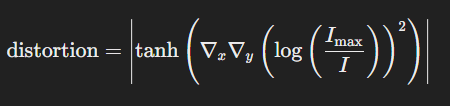

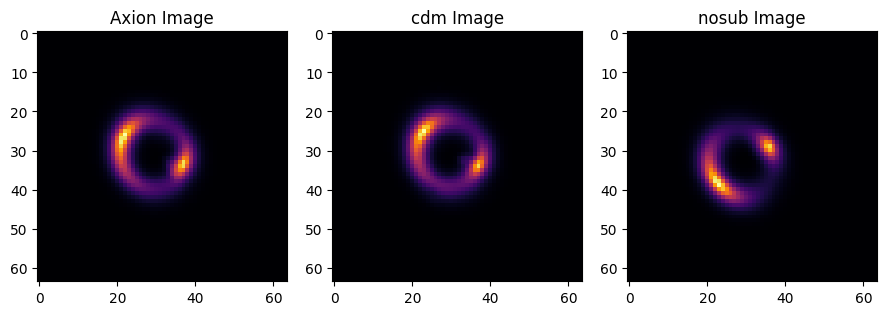

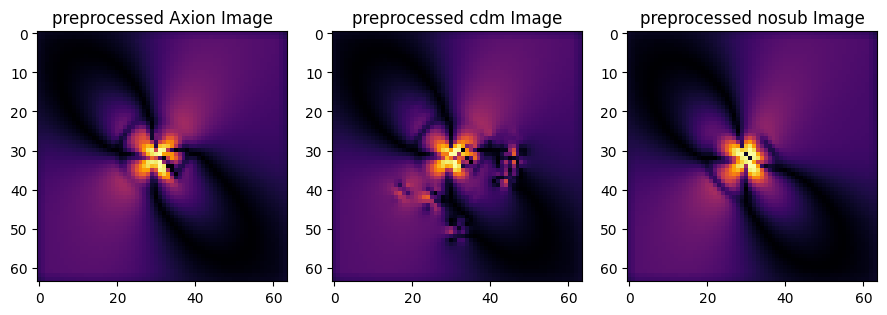

In [32]:
axion = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/axion/axion_sim_100084953578079617776821445184190256764.npy",allow_pickle = True)[0]
cdm = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/cdm/cdm_sim_100139434468354273490164714731456867252.npy",allow_pickle = True)
nosub = np.load("/kaggle/input/train-deeplense1-2/Model_II-001/Model_II/no_sub/no_sub_sim_100043654144385630537921390101531439263.npy",allow_pickle = True)
fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(axion, cmap="inferno")
axs[0].set_title("Axion Image")
axs[1].imshow(cdm, cmap="inferno")
axs[1].set_title("cdm Image")
axs[2].imshow(nosub, cmap="inferno")
axs[2].set_title("nosub Image")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].imshow(preprocess(axion), cmap="inferno")
axs[0].set_title("preprocessed Axion Image")
axs[1].imshow(preprocess(cdm), cmap="inferno")
axs[1].set_title("preprocessed cdm Image")
axs[2].imshow(preprocess(nosub), cmap="inferno")
axs[2].set_title("preprocessed nosub Image")
plt.tight_layout()
plt.show()

### Clearly, lensing images that seem very similar to each other can have very different differentials. The points where there are sudden changes in intensity may indicate the presence of dark matter.

In [33]:
model2 = True
if not model2:
    train_data = np.load("/kaggle/input/real-galaxy-tiny-dataset/data_train.npy")
    test_data = np.load("/kaggle/input/real-galaxy-tiny-dataset/data_test.npy")
    train_target = np.load("/kaggle/input/real-galaxy-tiny-dataset/labels_train.npy")
    test_target = np.load("/kaggle/input/real-galaxy-tiny-dataset/labels_test.npy")
    
    test_label = np.argmax(test_target,axis=1)
    train_label = np.argmax(train_target,axis=1)

In [34]:
class Dataset:
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        #image/=np.max(image)
        tar = self.target[idx]
        pre = preprocess(image)
        return torch.tensor(image, dtype=torch.float),torch.tensor(pre, dtype=torch.float), torch.tensor(tar, dtype=torch.long)



In [35]:
train_dataset = Dataset(train_data,train_label)
test_dataset = Dataset(test_data,test_label)


In [36]:
train_dataset[0]

(tensor([[1.2779e-09, 2.0083e-09, 3.3716e-09,  ..., 2.2093e-10, 1.2470e-10,
          7.5630e-11],
         [1.6791e-09, 2.6583e-09, 4.4999e-09,  ..., 3.3491e-10, 1.8789e-10,
          1.1334e-10],
         [2.3055e-09, 3.6807e-09, 6.2896e-09,  ..., 5.4163e-10, 3.0183e-10,
          1.8095e-10],
         ...,
         [3.2758e-12, 5.4172e-12, 9.6342e-12,  ..., 5.9270e-09, 3.7602e-09,
          2.5288e-09],
         [2.0292e-12, 3.3371e-12, 5.8987e-12,  ..., 3.9025e-09, 2.5006e-09,
          1.6966e-09],
         [1.3416e-12, 2.1955e-12, 3.8597e-12,  ..., 2.7208e-09, 1.7588e-09,
          1.2027e-09]]),
 tensor([[0.0652, 0.0576, 0.0485,  ..., 0.1881, 0.1649, 0.1431],
         [0.0625, 0.0536, 0.0427,  ..., 0.2132, 0.1878, 0.1640],
         [0.0592, 0.0488, 0.0361,  ..., 0.2389, 0.2114, 0.1856],
         ...,
         [0.1715, 0.1967, 0.2234,  ..., 0.0387, 0.0495, 0.0586],
         [0.1510, 0.1742, 0.1989,  ..., 0.0483, 0.0571, 0.0645],
         [0.1308, 0.1521, 0.1746,  ..., 0.0562, 0.0

In [37]:
from torch.utils.data import DataLoader
train_looader = DataLoader(train_dataset,batch_size = 64)
test_looader = DataLoader(test_dataset,batch_size = 64)

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [39]:
from sklearn.metrics import f1_score
def plot_model_metrics(mean_loss_train,mean_f1_train,model_name,mode):
    """
    Plots the training loss and ROC-AUC over epochs.

    Args:
        mean_loss_train (list): List of mean training loss over epochs.
        mean_auc_train (list): List of mean training ROC-AUC over epochs.

    Returns:
        None
    """
    # Plot training and testing loss over epochs
    plt.figure()
    plt.plot(mean_loss_train, label=mode)
    plt.title(model_name+' Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(mean_f1_train, label=mode)
    plt.title(model_name+' F1 - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.show()

    print('\n\n')


def train_final_model(model,total_training_loader,total_test_loader,n_epochs,optimizer,criterion,device,model_name):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    best_f1 = -2

    # loop over epochs
    for it in range(n_epochs):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []
        y_true = []
        y_pred = []

        # set model to train mode
        model.train()

        # loop over training data
        for images,dis, targets in tqdm(total_training_loader):

            # move data to device
            images,dis, targets = images.to(device),dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch,1,64,64)
            # zero the gradients
            optimizer.zero_grad()
            # forward pass
            if model_name == "resnet":
                outputs = model(images)
            else:
                info,source,outputs = model(images,dis)
            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            #print("epochloss = ",loss)
            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)
            train_f1.append(f1_score(labels,preds,average='micro'))
            #print(train_f1)
        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)
        #mat = confusion_matrix(y_true,y_pred)
        #disp = ConfusionMatrixDisplay(confusion_matrix=mat)
        #disp.plot()
        #plt.show()

        # initialize list to keep track of train loss for this epoch
        test_loss = []
        test_f1 = []

        # set model to train mode
        model.eval()
        y_true = []
        y_pred = []

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over training data
            for images,dis, targets in tqdm(total_test_loader):
                # move data to device
                images,dis, targets = images.to(device),dis.to(device), targets.to(device)
                batch = images.shape[0]
                images = images.view(batch,1,64,64)
                # forward pass
                if model_name == "resnet":
                    outputs = model(images)
                else:
                    info,source,outputs = model(images,dis)

                # compute loss
                loss = criterion(outputs, targets)

                # append loss to train_loss list
                test_loss.append(loss.item())

                # ROC Score
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()


                preds = [np.argmax(pred) for pred in preds]
                y_true.append(labels)
                y_pred.append(preds)
                #print(labels)
                #print(preds)
                test_f1.append(f1_score(labels,preds,average='micro'))

            y_true = np.hstack(y_true).reshape(-1)
            y_pred = np.hstack(y_pred).reshape(-1)
            #mat = confusion_matrix(y_true,y_pred)
            #disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            #disp.plot()
            #plt.show()


        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))

        if mean_f1_test[-1] > best_f1:
            best_f1 = mean_f1_test[-1]
            torch.save(model.state_dict(), "/kaggle/working/"+str(model_name)+"_best.pth")
            torch.save(model,"/kaggle/working/"+str(model_name)+"_complete.pth")


        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, bestf1:{best_f1}')


    # return lists of mean train
    return mean_loss_train,mean_f1_train,mean_loss_test,mean_f1_test


In [40]:
lens  = Lensformer(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=3,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lens.parameters(),lr=1e-4)


In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
mean_loss_train_lens,mean_f1_train_lens,mean_loss_test_lens,mean_f1_test_lens = train_final_model(lens,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name = "Lensformer")

100%|██████████| 188/188 [00:14<00:00, 13.30it/s]


Epoch 0/50, Train Loss: 0.8240, Train F1: 0.7186,Test Loss: 0.7872, Test F1: 0.7569, bestf1:0.7569486420051579


100%|██████████| 188/188 [00:14<00:00, 12.79it/s]


Epoch 1/50, Train Loss: 0.6577, Train F1: 0.8922,Test Loss: 0.7278, Test F1: 0.8199, bestf1:0.8198541263700838


100%|██████████| 188/188 [00:14<00:00, 13.38it/s]


Epoch 2/50, Train Loss: 0.6416, Train F1: 0.9087,Test Loss: 0.7170, Test F1: 0.8296, bestf1:0.8295781955190199


100%|██████████| 188/188 [00:14<00:00, 13.30it/s]


Epoch 3/50, Train Loss: 0.6416, Train F1: 0.9085,Test Loss: 0.6595, Test F1: 0.8893, bestf1:0.889330472275951


100%|██████████| 188/188 [00:14<00:00, 13.35it/s]


Epoch 4/50, Train Loss: 0.6428, Train F1: 0.9071,Test Loss: 0.6492, Test F1: 0.8990, bestf1:0.8989663926499033


100%|██████████| 188/188 [00:14<00:00, 13.37it/s]


Epoch 5/50, Train Loss: 0.6370, Train F1: 0.9133,Test Loss: 0.6236, Test F1: 0.9260, bestf1:0.9259525104771116


100%|██████████| 188/188 [00:13<00:00, 13.48it/s]


Epoch 6/50, Train Loss: 0.6326, Train F1: 0.9177,Test Loss: 0.5996, Test F1: 0.9514, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:13<00:00, 13.48it/s]


Epoch 7/50, Train Loss: 0.6343, Train F1: 0.9159,Test Loss: 0.6160, Test F1: 0.9343, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:14<00:00, 13.14it/s]


Epoch 8/50, Train Loss: 0.6253, Train F1: 0.9250,Test Loss: 0.6728, Test F1: 0.8755, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:13<00:00, 13.52it/s]


Epoch 9/50, Train Loss: 0.6192, Train F1: 0.9309,Test Loss: 0.6579, Test F1: 0.8906, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:14<00:00, 13.40it/s]


Epoch 10/50, Train Loss: 0.6217, Train F1: 0.9283,Test Loss: 0.6166, Test F1: 0.9329, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:14<00:00, 13.17it/s]


Epoch 11/50, Train Loss: 0.6167, Train F1: 0.9335,Test Loss: 0.6131, Test F1: 0.9377, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:13<00:00, 13.59it/s]


Epoch 12/50, Train Loss: 0.6135, Train F1: 0.9371,Test Loss: 0.6483, Test F1: 0.9024, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:13<00:00, 13.61it/s]


Epoch 13/50, Train Loss: 0.6136, Train F1: 0.9370,Test Loss: 0.6089, Test F1: 0.9411, bestf1:0.9513947654738878


100%|██████████| 188/188 [00:13<00:00, 13.65it/s]


Epoch 14/50, Train Loss: 0.6117, Train F1: 0.9385,Test Loss: 0.5870, Test F1: 0.9639, bestf1:0.963934558349452


100%|██████████| 188/188 [00:14<00:00, 13.29it/s]


Epoch 15/50, Train Loss: 0.6132, Train F1: 0.9374,Test Loss: 0.6798, Test F1: 0.8698, bestf1:0.963934558349452


100%|██████████| 188/188 [00:13<00:00, 13.63it/s]


Epoch 16/50, Train Loss: 0.6026, Train F1: 0.9477,Test Loss: 0.6132, Test F1: 0.9375, bestf1:0.963934558349452


100%|██████████| 188/188 [00:13<00:00, 13.58it/s]


Epoch 17/50, Train Loss: 0.6083, Train F1: 0.9419,Test Loss: 0.5972, Test F1: 0.9526, bestf1:0.963934558349452


100%|██████████| 188/188 [00:13<00:00, 13.64it/s]


Epoch 18/50, Train Loss: 0.6075, Train F1: 0.9430,Test Loss: 0.6513, Test F1: 0.8997, bestf1:0.963934558349452


100%|██████████| 188/188 [00:13<00:00, 13.50it/s]


Epoch 19/50, Train Loss: 0.6176, Train F1: 0.9330,Test Loss: 0.7783, Test F1: 0.7712, bestf1:0.963934558349452


100%|██████████| 188/188 [00:13<00:00, 13.66it/s]


Epoch 20/50, Train Loss: 0.6144, Train F1: 0.9359,Test Loss: 0.5854, Test F1: 0.9659, bestf1:0.9659292392005158


100%|██████████| 188/188 [00:13<00:00, 13.65it/s]


Epoch 21/50, Train Loss: 0.6186, Train F1: 0.9317,Test Loss: 0.5891, Test F1: 0.9615, bestf1:0.9659292392005158


100%|██████████| 188/188 [00:14<00:00, 13.25it/s]


Epoch 22/50, Train Loss: 0.5944, Train F1: 0.9561,Test Loss: 0.5877, Test F1: 0.9631, bestf1:0.9659292392005158


100%|██████████| 188/188 [00:13<00:00, 13.64it/s]


Epoch 23/50, Train Loss: 0.5996, Train F1: 0.9510,Test Loss: 0.5907, Test F1: 0.9595, bestf1:0.9659292392005158


100%|██████████| 188/188 [00:13<00:00, 13.72it/s]


Epoch 24/50, Train Loss: 0.6024, Train F1: 0.9483,Test Loss: 0.5829, Test F1: 0.9679, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.62it/s]


Epoch 25/50, Train Loss: 0.5949, Train F1: 0.9558,Test Loss: 0.6155, Test F1: 0.9348, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:14<00:00, 13.20it/s]


Epoch 26/50, Train Loss: 0.5990, Train F1: 0.9515,Test Loss: 0.5868, Test F1: 0.9642, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.66it/s]


Epoch 27/50, Train Loss: 0.6073, Train F1: 0.9432,Test Loss: 0.6064, Test F1: 0.9442, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.63it/s]


Epoch 28/50, Train Loss: 0.5965, Train F1: 0.9542,Test Loss: 0.5948, Test F1: 0.9560, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.80it/s]


Epoch 29/50, Train Loss: 0.6029, Train F1: 0.9478,Test Loss: 0.5968, Test F1: 0.9537, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.48it/s]


Epoch 30/50, Train Loss: 0.5918, Train F1: 0.9590,Test Loss: 0.6343, Test F1: 0.9141, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.55it/s]


Epoch 31/50, Train Loss: 0.6019, Train F1: 0.9484,Test Loss: 0.5966, Test F1: 0.9536, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 13.63it/s]


Epoch 32/50, Train Loss: 0.5967, Train F1: 0.9542,Test Loss: 0.5986, Test F1: 0.9516, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:14<00:00, 13.27it/s]


Epoch 33/50, Train Loss: 0.6002, Train F1: 0.9501,Test Loss: 0.5957, Test F1: 0.9550, bestf1:0.9679289571244358


100%|██████████| 188/188 [00:13<00:00, 14.15it/s]


Epoch 34/50, Train Loss: 0.6014, Train F1: 0.9490,Test Loss: 0.5821, Test F1: 0.9685, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.52it/s]


Epoch 35/50, Train Loss: 0.5999, Train F1: 0.9506,Test Loss: 0.6145, Test F1: 0.9359, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.55it/s]


Epoch 36/50, Train Loss: 0.5970, Train F1: 0.9536,Test Loss: 0.5921, Test F1: 0.9580, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.44it/s]


Epoch 37/50, Train Loss: 0.5918, Train F1: 0.9590,Test Loss: 0.5838, Test F1: 0.9670, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.58it/s]


Epoch 38/50, Train Loss: 0.6043, Train F1: 0.9463,Test Loss: 0.5953, Test F1: 0.9553, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.66it/s]


Epoch 39/50, Train Loss: 0.5919, Train F1: 0.9590,Test Loss: 0.6059, Test F1: 0.9453, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.50it/s]


Epoch 40/50, Train Loss: 0.5967, Train F1: 0.9540,Test Loss: 0.6366, Test F1: 0.9137, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:14<00:00, 13.42it/s]


Epoch 41/50, Train Loss: 0.5903, Train F1: 0.9606,Test Loss: 0.5913, Test F1: 0.9598, bestf1:0.9685057019664732


100%|██████████| 188/188 [00:13<00:00, 13.58it/s]


Epoch 42/50, Train Loss: 0.5905, Train F1: 0.9604,Test Loss: 0.5772, Test F1: 0.9738, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:13<00:00, 13.75it/s]


Epoch 43/50, Train Loss: 0.5930, Train F1: 0.9576,Test Loss: 0.5799, Test F1: 0.9705, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:14<00:00, 13.36it/s]


Epoch 44/50, Train Loss: 0.5933, Train F1: 0.9574,Test Loss: 0.6361, Test F1: 0.9134, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:13<00:00, 13.68it/s]


Epoch 45/50, Train Loss: 0.5915, Train F1: 0.9593,Test Loss: 0.5772, Test F1: 0.9737, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:13<00:00, 13.64it/s]


Epoch 46/50, Train Loss: 0.5920, Train F1: 0.9590,Test Loss: 0.5823, Test F1: 0.9682, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:13<00:00, 13.44it/s]


Epoch 47/50, Train Loss: 0.5886, Train F1: 0.9621,Test Loss: 0.5811, Test F1: 0.9698, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:13<00:00, 13.46it/s]


Epoch 48/50, Train Loss: 0.5903, Train F1: 0.9600,Test Loss: 0.5794, Test F1: 0.9717, bestf1:0.9738248509026435


100%|██████████| 188/188 [00:13<00:00, 14.30it/s]

Epoch 49/50, Train Loss: 0.5868, Train F1: 0.9638,Test Loss: 0.5899, Test F1: 0.9608, bestf1:0.9738248509026435


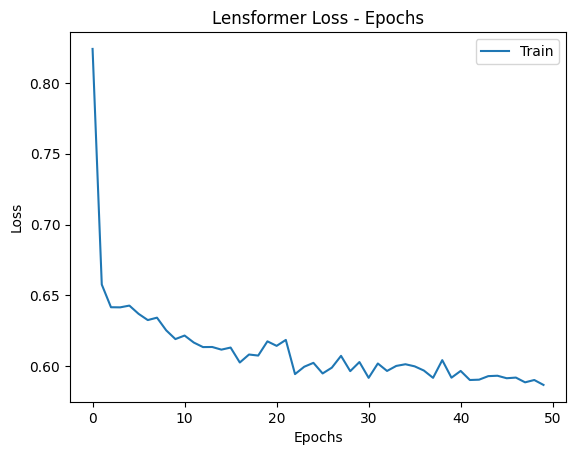

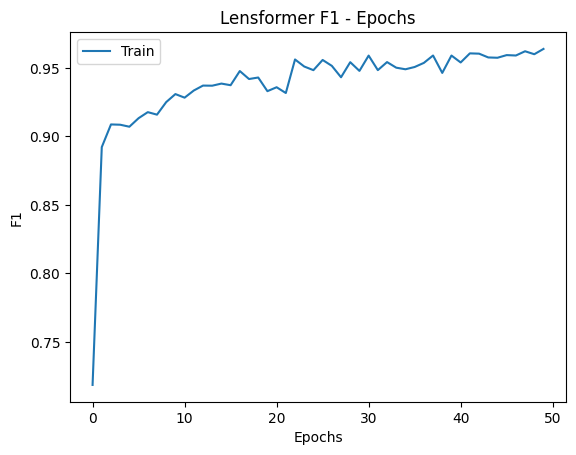

In [44]:
plot_model_metrics(mean_loss_train_lens,mean_f1_train_lens,model_name = "Lensformer",mode="Train")

# MY MODEL

The formula for the angular deflection for strong gravitational lensing is:

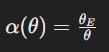
where theta is the angular distance, thetaE is the Einstein angle

**Approach:**
- The encoder encodes the Einstein angle .
- Instead of learning directly from the observed image, the network learns from the difference between the source and observed lensing images since The goal is to classify dark matter substructures responsible for these changes.


# THE BASIC ARCHITECTURE IS 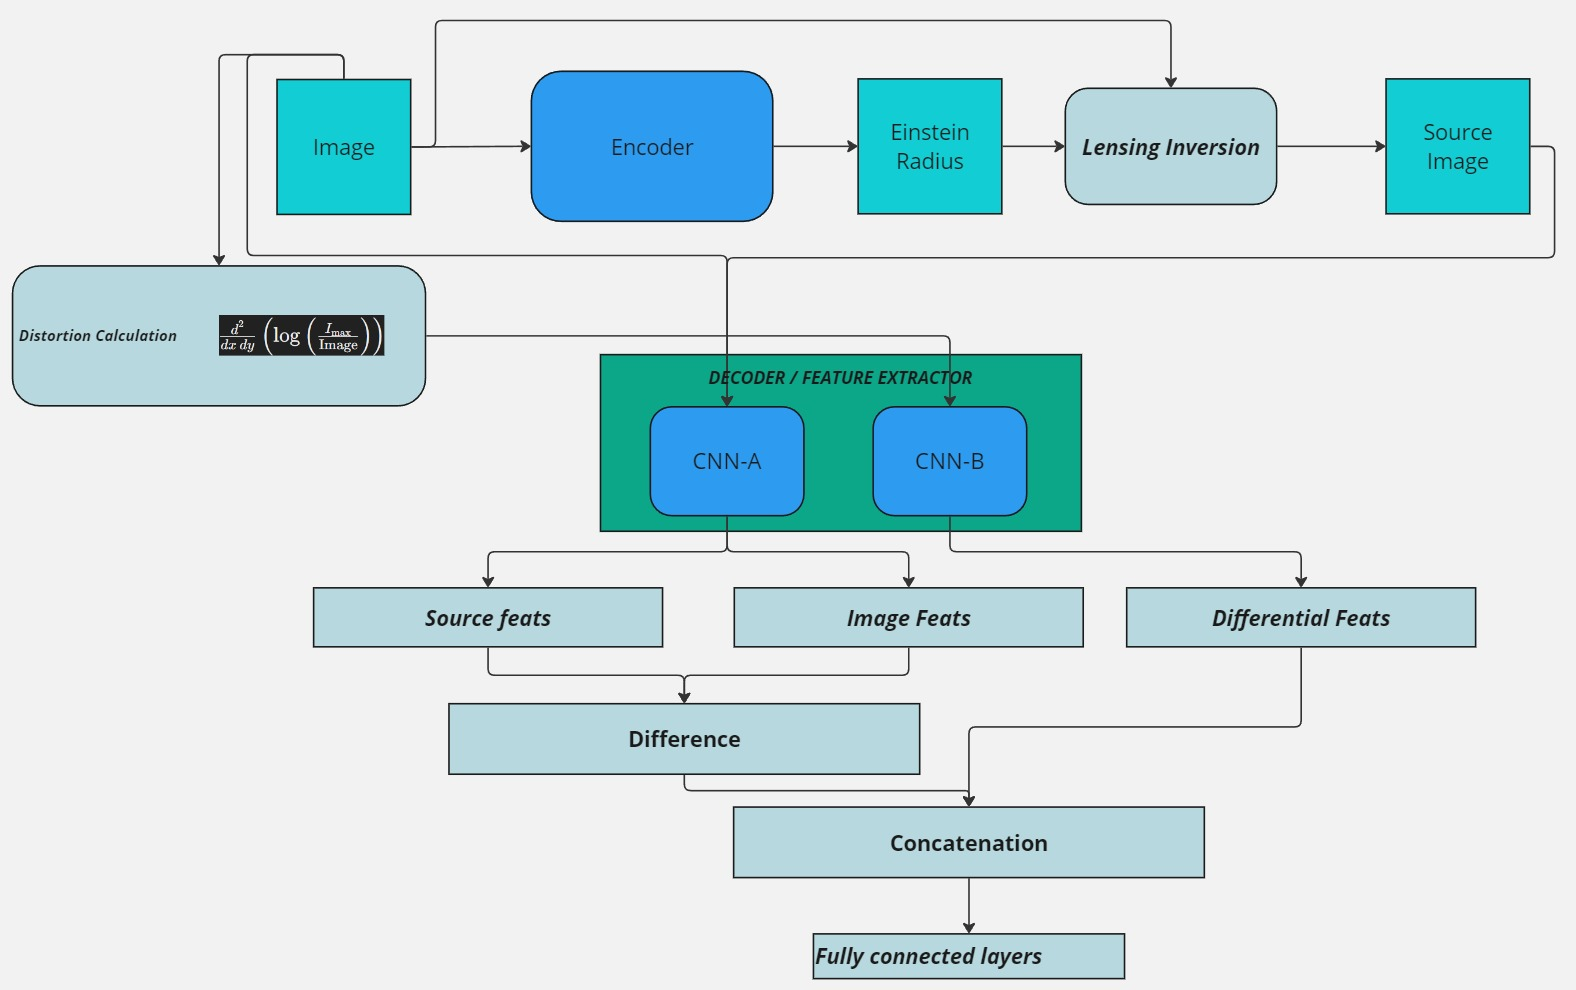

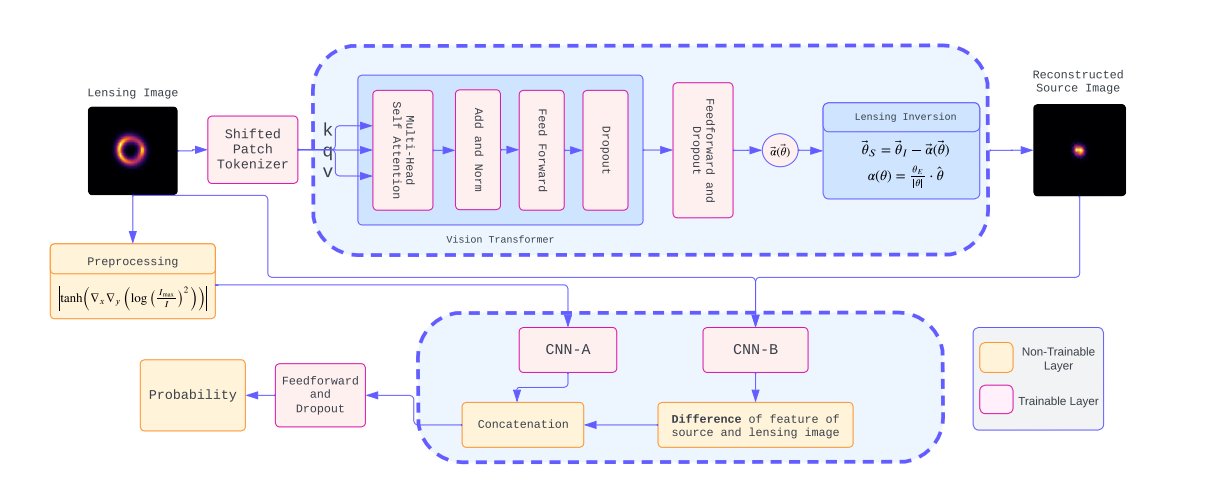

In [45]:
import torchvision.transforms.functional as F


In [46]:
class ChangedPhysicsInformedEncoder(nn.Module):
    def __init__(self, image_size, patch_size, embedding_dim, num_patches, num_heads,
                 hidden_dim, transformer_block_activation_function, num_transformer_block,
                 device: torch.device, k_max, k_min, num_hidden_layer=1, dropout=0.1, pixel_scale=0.101,
                 min_angle=-3.323, max_angle=3.232, mag=1):
        super().__init__()

        self.image_size = image_size
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_patches = num_patches
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.k_max = k_max
        self.k_min = k_min
        self.transformer_block_activation_function = transformer_block_activation_function
        self.num_transformer_block = num_transformer_block
        self.device = device
        self.dropout = dropout
        self.pixel_scale = pixel_scale
        self.min_angle = min_angle
        self.max_angle = max_angle
        self.source_mag = mag

        self.transformer = nn.ModuleList()

        for _ in range(self.num_transformer_block):
            self.transformer.append(
                TransformerLSABlock(embedding_dim=self.embedding_dim,
                                    num_head=self.num_heads,
                                    num_patches=self.num_patches,
                                    num_hidden_neurons=self.hidden_dim,
                                    num_hidden_layers=num_hidden_layer,
                                    activation_function=self.transformer_block_activation_function,
                                    device=self.device,
                                    dropout=dropout)
            )

        # Adding a compressor to give us the deflection angle for each pixel
        self.transformer.append(nn.Flatten())
        self.total_features = (self.num_patches + 1) * self.embedding_dim
        self.transformer.append(nn.Linear(self.total_features, 1))
        self.physics = Physics(mag=1)
        self.imones = torch.ones((self.image_size,self.image_size)).to(self.device)
        self.imones_1d = torch.ones((self.image_size*self.image_size)).to(self.device)
        # Create a grid for image coordinates
        self.profile_size = self.image_size
        self.half_profile_size = self.profile_size // 2

    def image_to_source(self, image, centre=None, E_r=None, deflection=None, gradient=None):
        length, width = image.shape
        pixel_width = (self.max_angle - self.min_angle) / length
        if centre is None:
            centre = (length // 2, width // 2)
        centre_x, centre_y = centre
        if False:
            centre_x = centre_x.item()
            centre_y = centre_y.item()
        
        range_indices_x = torch.arange(-(centre_x - 1), length - (centre_x - 1), device=self.device)
        range_indices_y = torch.arange(-(centre_y - 1), width - (centre_y - 1), device=self.device)

        x, y = torch.meshgrid(range_indices_x, range_indices_y, indexing='ij')
        x, y = x * pixel_width, y * pixel_width

        r = torch.sqrt(x**2 + y**2)
        mask = (r == 0)
        r[mask] = 1

        if deflection is not None:
            if deflection.shape != (length, width):
                raise ValueError(f"The deflection should be of shape (2, {length}, {width}) but got {deflection.shape}")
            xdef = (deflection * x) / r
            ydef = (deflection * y) / r
        elif gradient is not None:
            if gradient.shape != image.shape:
                raise ValueError("The gradient and image should be of the same shape")
            xdef = np.gradient(gradient, axis=0)
            ydef = np.gradient(gradient, axis=1)
        elif E_r is not None:
            k = torch.ones((length, width), device=self.device) * E_r
            xdef = (k * x) / r
            ydef = (k * y) / r
        else:
            raise ValueError("Both deflection and gradient cannot be None")

        bx = x - xdef
        by = y - ydef

        bx, by = bx / pixel_width, by / pixel_width

        bx = torch.clamp(bx + centre_x * self.source_mag, 0, length * self.source_mag - 1).long()
        by = torch.clamp(by + centre_y * self.source_mag, 0, width * self.source_mag - 1).long()

        # Initialize the output image tensor
        sourceimage = torch.zeros((length * self.source_mag, width * self.source_mag), dtype=torch.float, device=self.device)
        
        # Flatten the image and coordinates
        flat_image = image.view(-1)
        flat_bx = bx.view(-1)
        flat_by = by.view(-1)

        # Calculate 1D indices
        one_d_indices = flat_bx * (width * self.source_mag) + flat_by

        # Scatter add the values to sourceimage
        sourceimage_flat = sourceimage.view(-1)
        count  = torch.zeros_like(sourceimage_flat)
        sourceimage_flat = sourceimage_flat.scatter_add(0, one_d_indices, flat_image)
        count = count.scatter_add(0, one_d_indices, self.imones_1d)
        mask = count!=0
        sourceimage_flat[mask]/=count[mask]
        sourceimage = sourceimage_flat.view(sourceimage.shape)

        return sourceimage


    def forward(self, input_images, patches,distortion):
        # Move tensors to the appropriate device
        input_images = input_images.to(self.device)
        distortion = distortion.to(self.device)
        patches = patches.to(self.device)

        batch_size = input_images.shape[0]

        # Process patches through transformer layers
        k_sigmoid = patches
        for layer in self.transformer:
            k_sigmoid = layer(k_sigmoid)

        # Extract output components from k_sigmoid
        distortion = distortion.view(batch_size,self.image_size,self.image_size)
        einstein_angle = k_sigmoid

        # Reshape input images
        input_images = input_images.view(batch_size, self.image_size, self.image_size)

        # Initialize source_image tensor
        source_image = torch.zeros_like(input_images)

        # Transform each image in the batch
        for i in range(batch_size):
            source_image_np = self.image_to_source(image=input_images[i], E_r=einstein_angle[i])
            source_image[i] = source_image_np

        return k_sigmoid,source_image


In [47]:
class Decoder(nn.Module):
    def __init__(self,
                 image_size: int,
                 patch_size: int,
                 embed_dim: int,
                 in_channels: int,
                 num_classes: int,
                 num_heads: int,
                 num_hidden_neurons: int,
                 num_hidden_layers: int,
                 transformer_activation: nn.Module,
                 feedforward_activation: nn.Module,
                 num_transformer_blocks: int,
                 mode:str,
                 device: torch.device,
                 dropout_rate: float = 0.1):
        """
        Initializes Lensformer, a Relativistic Physics-Informed Vision Transformer (PIViT) Architecture for Dark Matter Morphology.

        Args:
            image_size (int): Size of the input image (assumed square).
            patch_size (int): Size of each image patch (assumed square).
            embed_dim (int): Dimension of the embedding space.
            in_channels (int): Number of input channels.
            num_classes (int): Number of target classes.
            num_heads (int): Number of attention heads.
            num_hidden_neurons (int): Number of neurons in hidden layers.
            num_hidden_layers (int): Number of hidden layers.
            transformer_activation (nn.Module): Activation function for transformer blocks.
            feedforward_activation (nn.Module): Activation function for feedforward layers.
            num_transformer_blocks (int): Number of transformer blocks.
            device (torch.device): Computational device (CPU/GPU).
            dropout_rate (float, optional): Dropout rate. Defaults to 0.1.
        """
        super(Decoder, self).__init__()

        # Initialize parameters
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.num_hidden_layers = num_hidden_layers
        self.transformer_activation = transformer_activation
        self.feedforward_activation = feedforward_activation
        self.num_transformer_blocks = num_transformer_blocks
        self.device = device
        self.dropout_rate = dropout_rate

        # Initialize modules
        self.initial_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        """self.secondary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)
        self.tertiary_tokenizer = ShiftPatchTokenizer(image_size=image_size, embedding_size=embed_dim, patch_size=patch_size, num_channels=in_channels, translation_mode="diagonal", device=device)"""
        self.encoder = ChangedPhysicsInformedEncoder(image_size=image_size, 
                                              patch_size=patch_size, 
                                              embedding_dim = embed_dim, 
                                              num_patches = self.initial_tokenizer.get_num_patches(), 
                                              num_heads=num_heads,
                                              hidden_dim=num_hidden_neurons, 
                                              transformer_block_activation_function=feedforward_activation, 
                                              num_transformer_block = num_transformer_blocks,
                                              device = device, 
                                              k_max = 1.2, 
                                              k_min = 0.8)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerLSABlock(embedding_dim = embed_dim,
                                num_head = num_heads,
                                num_patches = self.initial_tokenizer.get_num_patches(),
                                num_hidden_neurons=num_hidden_neurons,
                                num_hidden_layers=1,
                                activation_function=transformer_activation,
                                device=device)
            for _ in range(num_transformer_blocks)
        ])

        # Flatten and FeedForward layers
        self.flatten_layer = Flatten((self.initial_tokenizer.get_num_patches() + 1) * embed_dim)
        if mode=="large":
            self.decoder1 = timm.create_model("efficientnet_b0",pretrained = True)
            self.decoder1.conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.decoder2 = timm.create_model("efficientnet_b0",pretrained = True)
            self.decoder2.conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        if mode=="small":
            self.decoder1 = timm.create_model("mobilenetv3_small_050",pretrained = True)
            self.decoder1.conv_stem = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            self.decoder2 = timm.create_model("mobilenetv3_small_050",pretrained = True)
            self.decoder2.conv_stem = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        
        self.fc = FeedForwardBlock(in_dim = 1000*2,
                                                  out_dim = num_classes,
                                                  hidden_dim = num_hidden_neurons,
                                                  num_hidden_layers = num_hidden_layers,
                                                  activation_function = feedforward_activation,
                                                  task_type = 'multiclass',
                                                  dropout=dropout_rate)
        #self.fc = nn.Linear(1000*2,num_classes)
        
    def invert_lens(self, images: torch.Tensor) -> torch.Tensor:
        batch_size = images.size(0)
        images_T = images.reshape(batch_size, 1, self.image_size, self.image_size)
        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images_T)

        # Encode images and patches
        lens_corrected_images = self.encoder(images, initial_patches)

        return lens_corrected_images

    def forward(self, images: torch.Tensor,distortions) -> torch.Tensor:
        """
        Forward pass through the Physics-Informed Vision Transformer.

        Args:
            images (Tensor): Input images with shape (batch_size, channels, height, width).

        Returns:
            Tensor: Model predictions with shape (batch_size, num_classes).
        """
        images = images.to(self.device)
        distortions = distortions.to(self.device)
        batch_size = images.size(0)
        distortions = distortions.view(batch_size,1,self.image_size,self.image_size)

        # Tokenize input images into patches
        initial_patches = self.initial_tokenizer(images.reshape(batch_size, 1, self.image_size, self.image_size))
        
        info,lens_corrected_images = self.encoder(images, initial_patches,distortions)
        source = lens_corrected_images.view(batch_size,1,64,64)
        source = source.to(self.device)
        
        image_feats = self.decoder1(images)
        source_feats = self.decoder1(source)
        dis_feats = self.decoder2(distortions)
        
        # Pass through transformer blocks
        verbose = 2
        if verbose ==0:
            print("source_shape = ",source_patches.shape)
            print("observed_shape = ",initial_patches.shape)
            print("distortion_shape = ",dis_patches.shape)
            print("concat feats",concatenated.shape)

        """for block in self.transformer_blocks:
            dis_feats = block(key = dis_patches,value = dis_patches)
        #concatenated = torch.concat((dis_patches,source_feats,initial_patches),dim=2)
        # Flatten the patches"""
        concatenated = torch.concat((image_feats-source_feats,dis_feats),dim=1)
        #flattened_patches = self.flatten_layer(dis_feats)
        # Generate final predictions
        final_predictions = self.fc(concatenated)
        return info,source,final_predictions


In [48]:
model_small  = Decoder(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=1,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    mode = "small",
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")


model.safetensors:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

In [49]:
count_parameters(model_small)

+------------------------------------------------------+------------+
|                       Modules                        | Parameters |
+------------------------------------------------------+------------+
|          initial_tokenizer.class_embedding           |    384     |
|             initial_tokenizer.positional             |    1920    |
|          initial_tokenizer.tokenizer.weight          |  1966080   |
|           initial_tokenizer.tokenizer.bias           |    384     |
|          encoder.transformer.0.temperature           |     1      |
|    encoder.transformer.0.mlsa.mha.in_proj_weight     |   442368   |
|     encoder.transformer.0.mlsa.mha.in_proj_bias      |    1152    |
|    encoder.transformer.0.mlsa.mha.out_proj.weight    |   147456   |
|     encoder.transformer.0.mlsa.mha.out_proj.bias     |    384     |
|       encoder.transformer.0.first_norm.weight        |    384     |
|        encoder.transformer.0.first_norm.bias         |    384     |
| encoder.transforme

7173654

## this model has 14 million parameters 

In [50]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_small.parameters(),lr=1e-4)
model_small = model_small.to("cuda")

In [51]:
mean_loss_train_LensPINN_small,mean_f1_train_LensPINN_small,mean_loss_test_LensPINN_small,mean_f1_test_LensPINN_small = train_final_model(model_small,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="new_model")

100%|██████████| 188/188 [00:15<00:00, 11.89it/s]


Epoch 0/50, Train Loss: 0.6829, Train F1: 0.8727,Test Loss: 0.6120, Test F1: 0.9391, bestf1:0.9390992706318504


100%|██████████| 188/188 [00:16<00:00, 11.52it/s]


Epoch 1/50, Train Loss: 0.5948, Train F1: 0.9561,Test Loss: 0.5921, Test F1: 0.9610, bestf1:0.9610306858478401


100%|██████████| 188/188 [00:16<00:00, 11.52it/s]


Epoch 2/50, Train Loss: 0.5836, Train F1: 0.9674,Test Loss: 0.5907, Test F1: 0.9599, bestf1:0.9610306858478401


100%|██████████| 188/188 [00:16<00:00, 11.38it/s]


Epoch 3/50, Train Loss: 0.5772, Train F1: 0.9743,Test Loss: 0.5802, Test F1: 0.9707, bestf1:0.9706716432946486


100%|██████████| 188/188 [00:15<00:00, 11.91it/s]


Epoch 4/50, Train Loss: 0.5737, Train F1: 0.9775,Test Loss: 0.5792, Test F1: 0.9707, bestf1:0.9706716432946486


100%|██████████| 188/188 [00:16<00:00, 11.31it/s]


Epoch 5/50, Train Loss: 0.5698, Train F1: 0.9814,Test Loss: 0.5820, Test F1: 0.9683, bestf1:0.9706716432946486


100%|██████████| 188/188 [00:16<00:00, 11.61it/s]


Epoch 6/50, Train Loss: 0.5681, Train F1: 0.9832,Test Loss: 0.6281, Test F1: 0.9223, bestf1:0.9706716432946486


100%|██████████| 188/188 [00:15<00:00, 11.76it/s]


Epoch 7/50, Train Loss: 0.5678, Train F1: 0.9835,Test Loss: 0.5731, Test F1: 0.9782, bestf1:0.9782348081882656


100%|██████████| 188/188 [00:16<00:00, 11.52it/s]


Epoch 8/50, Train Loss: 0.5655, Train F1: 0.9858,Test Loss: 0.5708, Test F1: 0.9801, bestf1:0.9800582285622179


100%|██████████| 188/188 [00:16<00:00, 11.65it/s]


Epoch 9/50, Train Loss: 0.5642, Train F1: 0.9871,Test Loss: 0.5910, Test F1: 0.9593, bestf1:0.9800582285622179


100%|██████████| 188/188 [00:16<00:00, 11.74it/s]


Epoch 10/50, Train Loss: 0.5641, Train F1: 0.9872,Test Loss: 0.5699, Test F1: 0.9813, bestf1:0.9813049040941328


100%|██████████| 188/188 [00:16<00:00, 11.69it/s]


Epoch 11/50, Train Loss: 0.5645, Train F1: 0.9867,Test Loss: 0.6980, Test F1: 0.8510, bestf1:0.9813049040941328


100%|██████████| 188/188 [00:16<00:00, 11.34it/s]


Epoch 12/50, Train Loss: 0.5643, Train F1: 0.9871,Test Loss: 0.5677, Test F1: 0.9830, bestf1:0.982967138136686


100%|██████████| 188/188 [00:16<00:00, 11.44it/s]


Epoch 13/50, Train Loss: 0.5627, Train F1: 0.9885,Test Loss: 0.5663, Test F1: 0.9850, bestf1:0.9850449306898775


100%|██████████| 188/188 [00:16<00:00, 11.42it/s]


Epoch 14/50, Train Loss: 0.5616, Train F1: 0.9898,Test Loss: 0.6321, Test F1: 0.9181, bestf1:0.9850449306898775


100%|██████████| 188/188 [00:16<00:00, 11.70it/s]


Epoch 15/50, Train Loss: 0.5614, Train F1: 0.9900,Test Loss: 0.5646, Test F1: 0.9866, bestf1:0.9866190159574468


100%|██████████| 188/188 [00:15<00:00, 11.79it/s]


Epoch 16/50, Train Loss: 0.5605, Train F1: 0.9909,Test Loss: 0.5701, Test F1: 0.9811, bestf1:0.9866190159574468


100%|██████████| 188/188 [00:16<00:00, 11.54it/s]


Epoch 17/50, Train Loss: 0.5603, Train F1: 0.9913,Test Loss: 0.6824, Test F1: 0.8671, bestf1:0.9866190159574468


100%|██████████| 188/188 [00:16<00:00, 11.38it/s]


Epoch 18/50, Train Loss: 0.5618, Train F1: 0.9896,Test Loss: 0.5699, Test F1: 0.9811, bestf1:0.9866190159574468


100%|██████████| 188/188 [00:16<00:00, 11.71it/s]


Epoch 19/50, Train Loss: 0.5587, Train F1: 0.9926,Test Loss: 0.5687, Test F1: 0.9823, bestf1:0.9866190159574468


100%|██████████| 188/188 [00:16<00:00, 11.18it/s]


Epoch 20/50, Train Loss: 0.5579, Train F1: 0.9936,Test Loss: 0.5633, Test F1: 0.9881, bestf1:0.988120063668601


100%|██████████| 188/188 [00:16<00:00, 11.52it/s]


Epoch 21/50, Train Loss: 0.5582, Train F1: 0.9930,Test Loss: 0.5673, Test F1: 0.9837, bestf1:0.988120063668601


100%|██████████| 188/188 [00:16<00:00, 11.65it/s]


Epoch 22/50, Train Loss: 0.5583, Train F1: 0.9931,Test Loss: 0.5821, Test F1: 0.9688, bestf1:0.988120063668601


100%|██████████| 188/188 [00:16<00:00, 11.44it/s]


Epoch 23/50, Train Loss: 0.5579, Train F1: 0.9934,Test Loss: 0.5989, Test F1: 0.9519, bestf1:0.988120063668601


100%|██████████| 188/188 [00:16<00:00, 11.66it/s]


Epoch 24/50, Train Loss: 0.5584, Train F1: 0.9930,Test Loss: 0.5651, Test F1: 0.9861, bestf1:0.988120063668601


100%|██████████| 188/188 [00:16<00:00, 11.52it/s]


Epoch 25/50, Train Loss: 0.5577, Train F1: 0.9937,Test Loss: 0.5625, Test F1: 0.9887, bestf1:0.9886968085106383


100%|██████████| 188/188 [00:16<00:00, 11.23it/s]


Epoch 26/50, Train Loss: 0.5588, Train F1: 0.9925,Test Loss: 0.5893, Test F1: 0.9620, bestf1:0.9886968085106383


100%|██████████| 188/188 [00:16<00:00, 11.19it/s]


Epoch 27/50, Train Loss: 0.5577, Train F1: 0.9937,Test Loss: 0.5983, Test F1: 0.9526, bestf1:0.9886968085106383


100%|██████████| 188/188 [00:16<00:00, 11.31it/s]


Epoch 28/50, Train Loss: 0.5577, Train F1: 0.9937,Test Loss: 0.5640, Test F1: 0.9872, bestf1:0.9886968085106383


100%|██████████| 188/188 [00:16<00:00, 11.31it/s]


Epoch 29/50, Train Loss: 0.5572, Train F1: 0.9942,Test Loss: 0.5620, Test F1: 0.9893, bestf1:0.9892836274983882


100%|██████████| 188/188 [00:16<00:00, 11.16it/s]


Epoch 30/50, Train Loss: 0.5581, Train F1: 0.9932,Test Loss: 0.5620, Test F1: 0.9892, bestf1:0.9892836274983882


100%|██████████| 188/188 [00:16<00:00, 11.64it/s]


Epoch 31/50, Train Loss: 0.5567, Train F1: 0.9948,Test Loss: 0.5637, Test F1: 0.9873, bestf1:0.9892836274983882


100%|██████████| 188/188 [00:16<00:00, 11.46it/s]


Epoch 32/50, Train Loss: 0.5565, Train F1: 0.9948,Test Loss: 0.5609, Test F1: 0.9904, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.49it/s]


Epoch 33/50, Train Loss: 0.5576, Train F1: 0.9937,Test Loss: 0.5642, Test F1: 0.9870, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.60it/s]


Epoch 34/50, Train Loss: 0.5574, Train F1: 0.9940,Test Loss: 0.6115, Test F1: 0.9393, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.48it/s]


Epoch 35/50, Train Loss: 0.5573, Train F1: 0.9942,Test Loss: 0.5641, Test F1: 0.9872, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.29it/s]


Epoch 36/50, Train Loss: 0.5568, Train F1: 0.9946,Test Loss: 0.9029, Test F1: 0.6482, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.56it/s]


Epoch 37/50, Train Loss: 0.5568, Train F1: 0.9946,Test Loss: 0.5703, Test F1: 0.9808, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.54it/s]


Epoch 38/50, Train Loss: 0.5568, Train F1: 0.9946,Test Loss: 0.5609, Test F1: 0.9902, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.42it/s]


Epoch 39/50, Train Loss: 0.5576, Train F1: 0.9940,Test Loss: 0.7068, Test F1: 0.8439, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.57it/s]


Epoch 40/50, Train Loss: 0.5567, Train F1: 0.9948,Test Loss: 0.5621, Test F1: 0.9892, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.55it/s]


Epoch 41/50, Train Loss: 0.5562, Train F1: 0.9952,Test Loss: 0.5672, Test F1: 0.9841, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.54it/s]


Epoch 42/50, Train Loss: 0.5562, Train F1: 0.9952,Test Loss: 0.5611, Test F1: 0.9903, bestf1:0.9904421542553191


100%|██████████| 188/188 [00:16<00:00, 11.44it/s]


Epoch 43/50, Train Loss: 0.5560, Train F1: 0.9954,Test Loss: 0.5582, Test F1: 0.9932, bestf1:0.9931898774983882


100%|██████████| 188/188 [00:16<00:00, 11.46it/s]


Epoch 44/50, Train Loss: 0.5548, Train F1: 0.9966,Test Loss: 0.7882, Test F1: 0.7626, bestf1:0.9931898774983882


100%|██████████| 188/188 [00:16<00:00, 11.29it/s]


Epoch 45/50, Train Loss: 0.5557, Train F1: 0.9957,Test Loss: 0.5585, Test F1: 0.9929, bestf1:0.9931898774983882


100%|██████████| 188/188 [00:16<00:00, 11.17it/s]


Epoch 46/50, Train Loss: 0.5555, Train F1: 0.9959,Test Loss: 0.5582, Test F1: 0.9933, bestf1:0.9932729892005158


100%|██████████| 188/188 [00:16<00:00, 11.35it/s]


Epoch 47/50, Train Loss: 0.5577, Train F1: 0.9936,Test Loss: 0.5833, Test F1: 0.9680, bestf1:0.9932729892005158


100%|██████████| 188/188 [00:16<00:00, 11.32it/s]


Epoch 48/50, Train Loss: 0.5561, Train F1: 0.9953,Test Loss: 0.5608, Test F1: 0.9905, bestf1:0.9932729892005158


100%|██████████| 188/188 [00:16<00:00, 11.43it/s]

Epoch 49/50, Train Loss: 0.5565, Train F1: 0.9948,Test Loss: 0.5603, Test F1: 0.9910, bestf1:0.9932729892005158


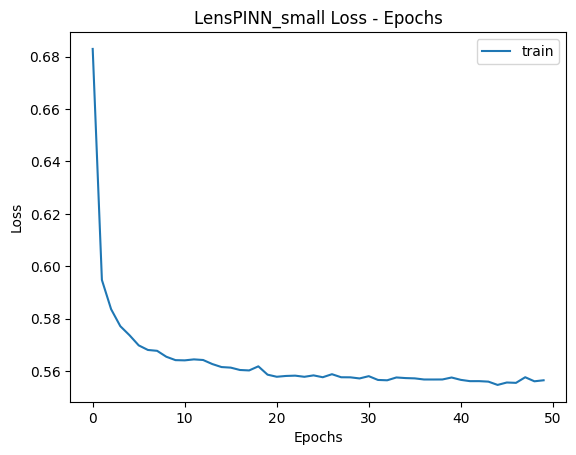

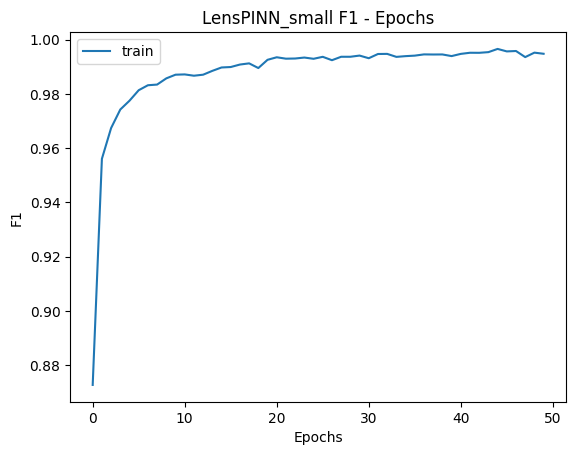

In [52]:
plot_model_metrics(mean_loss_train_LensPINN_small,mean_f1_train_LensPINN_small,model_name = "LensPINN_small",mode="train")

In [53]:
model_large  = Decoder(image_size=64,
                    patch_size=32,
                    embed_dim=384,
                    in_channels=1,
                    num_classes=3,
                    num_heads=16,
                    num_hidden_neurons=64,
                    num_hidden_layers=1,
                    transformer_activation=nn.ELU,
                    feedforward_activation=nn.ELU,
                    mode = "large",
                    num_transformer_blocks = 1,
                    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
                    ).to("cuda")

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_large.parameters(),lr=1e-4)
model_large = model_large.to("cuda")

In [55]:
mean_loss_train_LensPINN_large,mean_f1_train_LensPINN_large,mean_loss_test_LensPINN_large,mean_f1_test_LensPINN_large = train_final_model(model_large,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="LensPINN_large")

100%|██████████| 188/188 [00:18<00:00, 10.23it/s]


Epoch 0/50, Train Loss: 0.5999, Train F1: 0.9571,Test Loss: 0.5713, Test F1: 0.9791, bestf1:0.9791490369116699


100%|██████████| 188/188 [00:18<00:00, 10.19it/s]


Epoch 1/50, Train Loss: 0.5626, Train F1: 0.9887,Test Loss: 0.5898, Test F1: 0.9614, bestf1:0.9791490369116699


100%|██████████| 188/188 [00:18<00:00, 10.11it/s]


Epoch 2/50, Train Loss: 0.5623, Train F1: 0.9889,Test Loss: 0.5577, Test F1: 0.9937, bestf1:0.9936885477111541


100%|██████████| 188/188 [00:18<00:00, 10.39it/s]


Epoch 3/50, Train Loss: 0.5583, Train F1: 0.9931,Test Loss: 0.5545, Test F1: 0.9968, bestf1:0.9968467923920051


100%|██████████| 188/188 [00:18<00:00, 10.24it/s]


Epoch 4/50, Train Loss: 0.5591, Train F1: 0.9922,Test Loss: 0.5566, Test F1: 0.9944, bestf1:0.9968467923920051


100%|██████████| 188/188 [00:18<00:00, 10.37it/s]


Epoch 5/50, Train Loss: 0.5590, Train F1: 0.9924,Test Loss: 0.5537, Test F1: 0.9978, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.20it/s]


Epoch 6/50, Train Loss: 0.5570, Train F1: 0.9943,Test Loss: 0.5596, Test F1: 0.9919, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.39it/s]


Epoch 7/50, Train Loss: 0.5618, Train F1: 0.9896,Test Loss: 0.5641, Test F1: 0.9874, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.35it/s]


Epoch 8/50, Train Loss: 0.5590, Train F1: 0.9924,Test Loss: 0.5563, Test F1: 0.9951, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.37it/s]


Epoch 9/50, Train Loss: 0.5568, Train F1: 0.9945,Test Loss: 0.5539, Test F1: 0.9976, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.42it/s]


Epoch 10/50, Train Loss: 0.5593, Train F1: 0.9922,Test Loss: 0.5730, Test F1: 0.9785, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.37it/s]


Epoch 11/50, Train Loss: 0.5665, Train F1: 0.9848,Test Loss: 0.5819, Test F1: 0.9693, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.33it/s]


Epoch 12/50, Train Loss: 0.5586, Train F1: 0.9929,Test Loss: 0.5569, Test F1: 0.9944, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.38it/s]


Epoch 13/50, Train Loss: 0.5594, Train F1: 0.9921,Test Loss: 0.5746, Test F1: 0.9767, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.28it/s]


Epoch 14/50, Train Loss: 0.5593, Train F1: 0.9921,Test Loss: 0.5548, Test F1: 0.9967, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.37it/s]


Epoch 15/50, Train Loss: 0.5568, Train F1: 0.9947,Test Loss: 0.5570, Test F1: 0.9945, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:17<00:00, 10.46it/s]


Epoch 16/50, Train Loss: 0.5602, Train F1: 0.9912,Test Loss: 0.6040, Test F1: 0.9474, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.29it/s]


Epoch 17/50, Train Loss: 0.5588, Train F1: 0.9926,Test Loss: 0.5561, Test F1: 0.9953, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:18<00:00, 10.44it/s]


Epoch 18/50, Train Loss: 0.5580, Train F1: 0.9934,Test Loss: 0.5565, Test F1: 0.9949, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:17<00:00, 10.63it/s]


Epoch 19/50, Train Loss: 0.5564, Train F1: 0.9950,Test Loss: 0.5731, Test F1: 0.9783, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:17<00:00, 10.48it/s]


Epoch 20/50, Train Loss: 0.5871, Train F1: 0.9644,Test Loss: 0.5572, Test F1: 0.9942, bestf1:0.9977559840425532


100%|██████████| 188/188 [00:17<00:00, 10.58it/s]


Epoch 21/50, Train Loss: 0.5610, Train F1: 0.9904,Test Loss: 0.5532, Test F1: 0.9983, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.43it/s]


Epoch 22/50, Train Loss: 0.5574, Train F1: 0.9940,Test Loss: 0.5533, Test F1: 0.9982, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.28it/s]


Epoch 23/50, Train Loss: 0.5612, Train F1: 0.9903,Test Loss: 0.5538, Test F1: 0.9976, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.34it/s]


Epoch 24/50, Train Loss: 0.5564, Train F1: 0.9950,Test Loss: 0.5564, Test F1: 0.9950, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.37it/s]


Epoch 25/50, Train Loss: 0.5595, Train F1: 0.9919,Test Loss: 0.5968, Test F1: 0.9545, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.38it/s]


Epoch 26/50, Train Loss: 0.5607, Train F1: 0.9907,Test Loss: 0.5532, Test F1: 0.9983, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:17<00:00, 10.51it/s]


Epoch 27/50, Train Loss: 0.5561, Train F1: 0.9953,Test Loss: 0.5545, Test F1: 0.9969, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:17<00:00, 10.49it/s]


Epoch 28/50, Train Loss: 0.5634, Train F1: 0.9880,Test Loss: 0.5879, Test F1: 0.9635, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:17<00:00, 10.47it/s]


Epoch 29/50, Train Loss: 0.5572, Train F1: 0.9942,Test Loss: 0.5536, Test F1: 0.9978, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.44it/s]


Epoch 30/50, Train Loss: 0.5562, Train F1: 0.9952,Test Loss: 0.5564, Test F1: 0.9950, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.28it/s]


Epoch 31/50, Train Loss: 0.5561, Train F1: 0.9954,Test Loss: 0.5551, Test F1: 0.9963, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.35it/s]


Epoch 32/50, Train Loss: 0.5557, Train F1: 0.9957,Test Loss: 0.5553, Test F1: 0.9962, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.17it/s]


Epoch 33/50, Train Loss: 0.5596, Train F1: 0.9918,Test Loss: 0.5577, Test F1: 0.9938, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.21it/s]


Epoch 34/50, Train Loss: 0.5621, Train F1: 0.9893,Test Loss: 0.5782, Test F1: 0.9732, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.10it/s]


Epoch 35/50, Train Loss: 0.5638, Train F1: 0.9877,Test Loss: 0.5718, Test F1: 0.9794, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.15it/s]


Epoch 36/50, Train Loss: 0.5720, Train F1: 0.9794,Test Loss: 0.5739, Test F1: 0.9776, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.02it/s]


Epoch 37/50, Train Loss: 0.5652, Train F1: 0.9862,Test Loss: 0.6023, Test F1: 0.9491, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.15it/s]


Epoch 38/50, Train Loss: 0.5600, Train F1: 0.9914,Test Loss: 0.5534, Test F1: 0.9980, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.24it/s]


Epoch 39/50, Train Loss: 0.5581, Train F1: 0.9933,Test Loss: 0.5886, Test F1: 0.9627, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.26it/s]


Epoch 40/50, Train Loss: 0.5586, Train F1: 0.9929,Test Loss: 0.5549, Test F1: 0.9965, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.34it/s]


Epoch 41/50, Train Loss: 0.5593, Train F1: 0.9922,Test Loss: 0.5583, Test F1: 0.9931, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.23it/s]


Epoch 42/50, Train Loss: 0.5572, Train F1: 0.9942,Test Loss: 0.5636, Test F1: 0.9879, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.38it/s]


Epoch 43/50, Train Loss: 0.5637, Train F1: 0.9878,Test Loss: 0.5584, Test F1: 0.9931, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:17<00:00, 10.47it/s]


Epoch 44/50, Train Loss: 0.5640, Train F1: 0.9875,Test Loss: 0.5571, Test F1: 0.9943, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.44it/s]


Epoch 45/50, Train Loss: 0.5607, Train F1: 0.9907,Test Loss: 0.7036, Test F1: 0.8477, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.44it/s]


Epoch 46/50, Train Loss: 0.5615, Train F1: 0.9899,Test Loss: 0.5587, Test F1: 0.9927, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.40it/s]


Epoch 47/50, Train Loss: 0.5576, Train F1: 0.9938,Test Loss: 0.5553, Test F1: 0.9962, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:17<00:00, 10.50it/s]


Epoch 48/50, Train Loss: 0.5658, Train F1: 0.9856,Test Loss: 0.5696, Test F1: 0.9817, bestf1:0.9982546542553191


100%|██████████| 188/188 [00:18<00:00, 10.06it/s]

Epoch 49/50, Train Loss: 0.5606, Train F1: 0.9908,Test Loss: 0.5545, Test F1: 0.9969, bestf1:0.9982546542553191


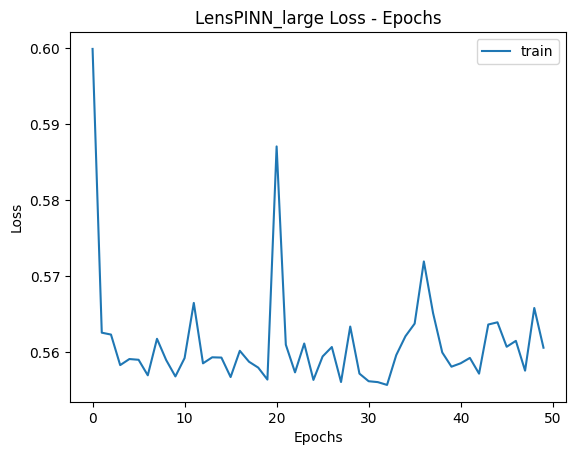

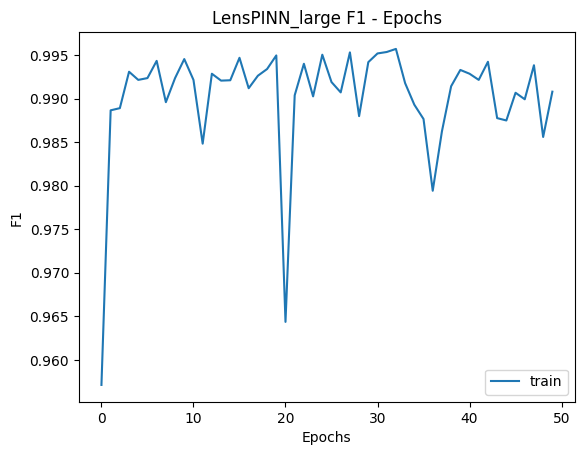

In [56]:
plot_model_metrics(mean_loss_train_LensPINN_large,mean_f1_train_LensPINN_large,model_name = "LensPINN_large",mode="train")

## ResNet

In [57]:
import timm

In [58]:
resnet = timm.create_model("resnet18",pretrained = True)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet.fc = nn.Linear(512,3)

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [59]:
def train_final_model_other(model,total_training_loader,total_test_loader,n_epochs,optimizer,criterion,device,model_name):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    best_f1 = -2

    # loop over epochs
    for it in range(n_epochs):

        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_f1 = []
        y_true = []
        y_pred = []

        # set model to train mode
        model.train()

        # loop over training data
        for images,dis, targets in tqdm(total_training_loader):

            # move data to device
            images,dis, targets = images.to(device),dis.to(device), targets.to(device)
            batch = images.shape[0]
            images = images.view(batch,1,64,64)
            dis = dis.view(batch,1,64,64)
            # zero the gradients
            optimizer.zero_grad()
            # forward pass
            outputs = model(images)
            # compute loss
            loss = criterion(outputs, targets)

            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            #print("epochloss = ",loss)
            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            y_true.append(labels)
            y_pred.append(preds)
            train_f1.append(f1_score(labels,preds,average='micro'))
            #print(train_f1)
        y_true = np.hstack(y_true).reshape(-1)
        y_pred = np.hstack(y_pred).reshape(-1)
        """mat = confusion_matrix(y_true,y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=mat)
        disp.plot()
        plt.show()"""

        # initialize list to keep track of train loss for this epoch
        test_loss = []
        test_f1 = []

        # set model to train mode
        model.eval()
        y_true = []
        y_pred = []

        # turn off gradients for evaluation
        with torch.no_grad():

          # loop over training data
            for images,dis, targets in tqdm(total_test_loader):
                # move data to device
                images,dis, targets = images.to(device),dis.to(device), targets.to(device)
                batch = images.shape[0]
                images = images.view(batch,1,64,64)
                dis = dis.view(batch,1,64,64)
                # forward pass
                #print(images.shape)
                outputs = model(images)

                # compute loss
                loss = criterion(outputs, targets)

                # append loss to train_loss list
                test_loss.append(loss.item())

                # ROC Score
                preds = outputs.detach().cpu().numpy()
                labels = targets.detach().cpu().numpy()


                preds = [np.argmax(pred) for pred in preds]
                y_true.append(labels)
                y_pred.append(preds)
                #print(labels)
                #print(preds)
                test_f1.append(f1_score(labels,preds,average='micro'))

            y_true = np.hstack(y_true).reshape(-1)
            y_pred = np.hstack(y_pred).reshape(-1)
            """mat = confusion_matrix(y_true,y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=mat)
            disp.plot()
            plt.show()"""


        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))

        if mean_f1_test[-1] > best_f1:
            best_f1 = mean_f1_test[-1]
            torch.save(model.state_dict(), "/kaggle/working/"+str(model_name)+"_best.pth")
            torch.save(model,"/kaggle/working/"+str(model_name)+"_complete.pth")


        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f},Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}, bestf1:{best_f1:.4f}')


    # return lists of mean train
    return mean_loss_train,mean_f1_train,mean_loss_test,mean_f1_test


In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(),lr=1e-4)
resnet = resnet.to("cuda")

In [61]:
mean_loss_train_resnet,mean_f1_train_resnet,mean_loss_test_resnet,mean_f1_test_resnet = train_final_model(resnet,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="resnet")

100%|██████████| 188/188 [00:03<00:00, 47.11it/s]


Epoch 0/50, Train Loss: 0.7315, Train F1: 0.6779,Test Loss: 0.5005, Test F1: 0.7951, bestf1:0.7950666908446163


100%|██████████| 188/188 [00:03<00:00, 48.43it/s]


Epoch 1/50, Train Loss: 0.4380, Train F1: 0.8189,Test Loss: 0.4186, Test F1: 0.8250, bestf1:0.8249768294648614


100%|██████████| 188/188 [00:04<00:00, 46.58it/s]


Epoch 2/50, Train Loss: 0.3447, Train F1: 0.8597,Test Loss: 0.4199, Test F1: 0.8268, bestf1:0.8268103239845261


100%|██████████| 188/188 [00:04<00:00, 46.36it/s]


Epoch 3/50, Train Loss: 0.2941, Train F1: 0.8803,Test Loss: 0.4742, Test F1: 0.8158, bestf1:0.8268103239845261


100%|██████████| 188/188 [00:04<00:00, 46.12it/s]


Epoch 4/50, Train Loss: 0.2599, Train F1: 0.8942,Test Loss: 0.4835, Test F1: 0.8271, bestf1:0.8270596590909091


100%|██████████| 188/188 [00:03<00:00, 47.63it/s]


Epoch 5/50, Train Loss: 0.2298, Train F1: 0.9060,Test Loss: 0.4127, Test F1: 0.8517, bestf1:0.851743834622824


100%|██████████| 188/188 [00:03<00:00, 49.08it/s]


Epoch 6/50, Train Loss: 0.2059, Train F1: 0.9159,Test Loss: 0.5098, Test F1: 0.8309, bestf1:0.851743834622824


100%|██████████| 188/188 [00:03<00:00, 49.28it/s]


Epoch 7/50, Train Loss: 0.1844, Train F1: 0.9255,Test Loss: 0.3977, Test F1: 0.8631, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:04<00:00, 45.90it/s]


Epoch 8/50, Train Loss: 0.1696, Train F1: 0.9322,Test Loss: 0.5254, Test F1: 0.8326, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:03<00:00, 47.52it/s]


Epoch 9/50, Train Loss: 0.1505, Train F1: 0.9402,Test Loss: 0.6109, Test F1: 0.8246, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:04<00:00, 44.93it/s]


Epoch 10/50, Train Loss: 0.1364, Train F1: 0.9462,Test Loss: 0.6924, Test F1: 0.8072, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:04<00:00, 46.67it/s]


Epoch 11/50, Train Loss: 0.1287, Train F1: 0.9509,Test Loss: 0.5073, Test F1: 0.8576, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:03<00:00, 47.68it/s]


Epoch 12/50, Train Loss: 0.1192, Train F1: 0.9548,Test Loss: 0.4737, Test F1: 0.8563, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:03<00:00, 47.12it/s]


Epoch 13/50, Train Loss: 0.1132, Train F1: 0.9571,Test Loss: 0.6146, Test F1: 0.8241, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:03<00:00, 47.06it/s]


Epoch 14/50, Train Loss: 0.1089, Train F1: 0.9580,Test Loss: 0.4962, Test F1: 0.8568, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:03<00:00, 47.64it/s]


Epoch 15/50, Train Loss: 0.1007, Train F1: 0.9620,Test Loss: 0.4695, Test F1: 0.8621, bestf1:0.8631301378143134


100%|██████████| 188/188 [00:04<00:00, 44.68it/s]


Epoch 16/50, Train Loss: 0.1013, Train F1: 0.9615,Test Loss: 0.4399, Test F1: 0.8790, bestf1:0.8790044729206963


100%|██████████| 188/188 [00:04<00:00, 46.62it/s]


Epoch 17/50, Train Loss: 0.0999, Train F1: 0.9617,Test Loss: 0.4961, Test F1: 0.8717, bestf1:0.8790044729206963


100%|██████████| 188/188 [00:04<00:00, 46.58it/s]


Epoch 18/50, Train Loss: 0.0856, Train F1: 0.9680,Test Loss: 0.6324, Test F1: 0.8392, bestf1:0.8790044729206963


100%|██████████| 188/188 [00:03<00:00, 47.56it/s]


Epoch 19/50, Train Loss: 0.0801, Train F1: 0.9702,Test Loss: 0.4261, Test F1: 0.8847, bestf1:0.8846611057382334


100%|██████████| 188/188 [00:04<00:00, 46.54it/s]


Epoch 20/50, Train Loss: 0.0757, Train F1: 0.9722,Test Loss: 0.6568, Test F1: 0.8427, bestf1:0.8846611057382334


100%|██████████| 188/188 [00:04<00:00, 42.22it/s]


Epoch 21/50, Train Loss: 0.0771, Train F1: 0.9707,Test Loss: 0.4066, Test F1: 0.8973, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:04<00:00, 46.31it/s]


Epoch 22/50, Train Loss: 0.0743, Train F1: 0.9720,Test Loss: 0.4588, Test F1: 0.8866, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:03<00:00, 47.77it/s]


Epoch 23/50, Train Loss: 0.0671, Train F1: 0.9757,Test Loss: 0.5241, Test F1: 0.8930, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:03<00:00, 47.98it/s]


Epoch 24/50, Train Loss: 0.0663, Train F1: 0.9752,Test Loss: 0.8315, Test F1: 0.8025, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:03<00:00, 48.14it/s]


Epoch 25/50, Train Loss: 0.0613, Train F1: 0.9772,Test Loss: 0.5705, Test F1: 0.8683, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:03<00:00, 47.59it/s]


Epoch 26/50, Train Loss: 0.0666, Train F1: 0.9757,Test Loss: 0.4705, Test F1: 0.8961, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:03<00:00, 47.80it/s]


Epoch 27/50, Train Loss: 0.0635, Train F1: 0.9767,Test Loss: 0.4920, Test F1: 0.8870, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:03<00:00, 48.43it/s]


Epoch 28/50, Train Loss: 0.0553, Train F1: 0.9799,Test Loss: 1.0110, Test F1: 0.8103, bestf1:0.8972840103159252


100%|██████████| 188/188 [00:04<00:00, 46.83it/s]


Epoch 29/50, Train Loss: 0.0586, Train F1: 0.9789,Test Loss: 0.4999, Test F1: 0.8997, bestf1:0.8996942496776273


100%|██████████| 188/188 [00:03<00:00, 47.89it/s]


Epoch 30/50, Train Loss: 0.0552, Train F1: 0.9799,Test Loss: 0.4715, Test F1: 0.8960, bestf1:0.8996942496776273


100%|██████████| 188/188 [00:03<00:00, 48.68it/s]


Epoch 31/50, Train Loss: 0.0541, Train F1: 0.9801,Test Loss: 0.4433, Test F1: 0.9044, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:04<00:00, 41.12it/s]


Epoch 32/50, Train Loss: 0.0552, Train F1: 0.9798,Test Loss: 0.5115, Test F1: 0.8940, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:04<00:00, 46.43it/s]


Epoch 33/50, Train Loss: 0.0509, Train F1: 0.9821,Test Loss: 0.5687, Test F1: 0.8847, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.68it/s]


Epoch 34/50, Train Loss: 0.0485, Train F1: 0.9824,Test Loss: 0.5388, Test F1: 0.8921, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 48.73it/s]


Epoch 35/50, Train Loss: 0.0484, Train F1: 0.9829,Test Loss: 0.9168, Test F1: 0.8250, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.86it/s]


Epoch 36/50, Train Loss: 0.0457, Train F1: 0.9840,Test Loss: 0.5836, Test F1: 0.8798, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.03it/s]


Epoch 37/50, Train Loss: 0.0519, Train F1: 0.9817,Test Loss: 0.8246, Test F1: 0.8419, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 48.04it/s]


Epoch 38/50, Train Loss: 0.0453, Train F1: 0.9839,Test Loss: 0.6233, Test F1: 0.8828, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.86it/s]


Epoch 39/50, Train Loss: 0.0461, Train F1: 0.9835,Test Loss: 0.6396, Test F1: 0.8838, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:04<00:00, 45.73it/s]


Epoch 40/50, Train Loss: 0.0403, Train F1: 0.9851,Test Loss: 0.4561, Test F1: 0.8991, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:04<00:00, 46.13it/s]


Epoch 41/50, Train Loss: 0.0452, Train F1: 0.9840,Test Loss: 0.5013, Test F1: 0.9008, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.04it/s]


Epoch 42/50, Train Loss: 0.0432, Train F1: 0.9851,Test Loss: 0.4734, Test F1: 0.9040, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:04<00:00, 41.33it/s]


Epoch 43/50, Train Loss: 0.0388, Train F1: 0.9864,Test Loss: 0.4268, Test F1: 0.9043, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.98it/s]


Epoch 44/50, Train Loss: 0.0433, Train F1: 0.9846,Test Loss: 0.8745, Test F1: 0.8465, bestf1:0.9043535420696325


100%|██████████| 188/188 [00:03<00:00, 47.15it/s]


Epoch 45/50, Train Loss: 0.0387, Train F1: 0.9863,Test Loss: 0.4268, Test F1: 0.9096, bestf1:0.909589579303675


100%|██████████| 188/188 [00:04<00:00, 46.45it/s]


Epoch 46/50, Train Loss: 0.0386, Train F1: 0.9867,Test Loss: 0.4754, Test F1: 0.8988, bestf1:0.909589579303675


100%|██████████| 188/188 [00:04<00:00, 46.69it/s]


Epoch 47/50, Train Loss: 0.0374, Train F1: 0.9865,Test Loss: 0.4435, Test F1: 0.9060, bestf1:0.909589579303675


100%|██████████| 188/188 [00:04<00:00, 46.33it/s]


Epoch 48/50, Train Loss: 0.0401, Train F1: 0.9855,Test Loss: 0.4804, Test F1: 0.8975, bestf1:0.909589579303675


100%|██████████| 188/188 [00:03<00:00, 48.85it/s]

Epoch 49/50, Train Loss: 0.0377, Train F1: 0.9865,Test Loss: 0.7135, Test F1: 0.8695, bestf1:0.909589579303675


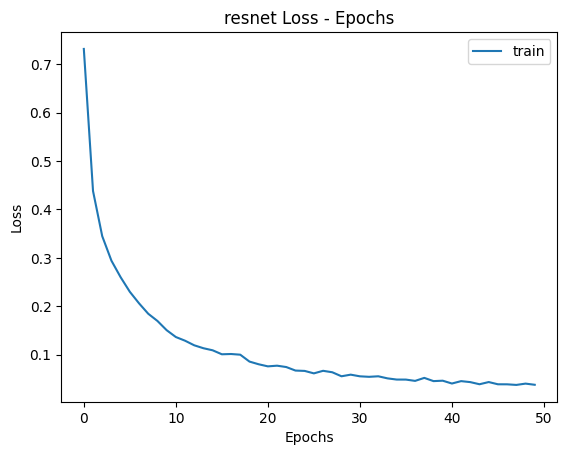

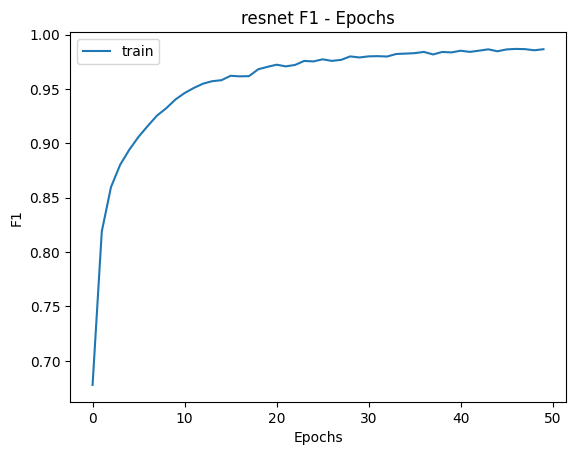

In [62]:
plot_model_metrics(mean_loss_train_resnet,mean_f1_train_resnet,model_name = "resnet",mode="train")

In [63]:
pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Vision Transformer

In [64]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [65]:
ViTr = ViT(
    image_size = 64,
    patch_size = 32,
    num_classes = 3,
    dim = 1024,
    depth = 2,
    heads = 24,
    mlp_dim = 16,
    dropout = 0.1,
    channels = 1,
    emb_dropout = 0.1,
    pool = 'cls'
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(ViTr.parameters(),lr=1e-4)
ViTr = ViTr.to("cuda")

In [66]:
mean_loss_train_Vit,mean_f1_train_Vit,mean_loss_test_Vit,mean_f1_test_Vit = train_final_model_other(ViTr,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="Vision Transformer")

100%|██████████| 188/188 [00:03<00:00, 48.10it/s]


Epoch 0/50, Train Loss: 0.5999, Train F1: 0.7272,Test Loss: 0.4853, Test F1: 0.8043, bestf1:0.8043


100%|██████████| 188/188 [00:03<00:00, 57.14it/s]


Epoch 1/50, Train Loss: 0.4463, Train F1: 0.8128,Test Loss: 0.5694, Test F1: 0.7885, bestf1:0.8043


100%|██████████| 188/188 [00:03<00:00, 53.36it/s]


Epoch 2/50, Train Loss: 0.4155, Train F1: 0.8268,Test Loss: 0.4659, Test F1: 0.8211, bestf1:0.8211


100%|██████████| 188/188 [00:03<00:00, 57.43it/s]


Epoch 3/50, Train Loss: 0.3910, Train F1: 0.8376,Test Loss: 0.4118, Test F1: 0.8355, bestf1:0.8355


100%|██████████| 188/188 [00:03<00:00, 55.82it/s]


Epoch 4/50, Train Loss: 0.3772, Train F1: 0.8436,Test Loss: 0.4507, Test F1: 0.8208, bestf1:0.8355


100%|██████████| 188/188 [00:03<00:00, 52.61it/s]


Epoch 5/50, Train Loss: 0.3684, Train F1: 0.8471,Test Loss: 0.3551, Test F1: 0.8556, bestf1:0.8556


100%|██████████| 188/188 [00:03<00:00, 56.56it/s]


Epoch 6/50, Train Loss: 0.3613, Train F1: 0.8500,Test Loss: 0.3602, Test F1: 0.8518, bestf1:0.8556


100%|██████████| 188/188 [00:03<00:00, 57.64it/s]


Epoch 7/50, Train Loss: 0.3497, Train F1: 0.8567,Test Loss: 0.3314, Test F1: 0.8661, bestf1:0.8661


100%|██████████| 188/188 [00:03<00:00, 55.68it/s]


Epoch 8/50, Train Loss: 0.3477, Train F1: 0.8568,Test Loss: 0.4061, Test F1: 0.8496, bestf1:0.8661


100%|██████████| 188/188 [00:03<00:00, 56.80it/s]


Epoch 9/50, Train Loss: 0.3385, Train F1: 0.8618,Test Loss: 0.3208, Test F1: 0.8709, bestf1:0.8709


100%|██████████| 188/188 [00:03<00:00, 56.91it/s]


Epoch 10/50, Train Loss: 0.3325, Train F1: 0.8631,Test Loss: 0.3673, Test F1: 0.8576, bestf1:0.8709


100%|██████████| 188/188 [00:03<00:00, 56.99it/s]


Epoch 11/50, Train Loss: 0.3273, Train F1: 0.8657,Test Loss: 0.3034, Test F1: 0.8793, bestf1:0.8793


100%|██████████| 188/188 [00:03<00:00, 56.92it/s]


Epoch 12/50, Train Loss: 0.3239, Train F1: 0.8684,Test Loss: 0.3108, Test F1: 0.8753, bestf1:0.8793


100%|██████████| 188/188 [00:03<00:00, 57.60it/s]


Epoch 13/50, Train Loss: 0.3191, Train F1: 0.8700,Test Loss: 0.3114, Test F1: 0.8661, bestf1:0.8793


100%|██████████| 188/188 [00:03<00:00, 59.76it/s]


Epoch 14/50, Train Loss: 0.3154, Train F1: 0.8722,Test Loss: 0.2909, Test F1: 0.8825, bestf1:0.8825


100%|██████████| 188/188 [00:03<00:00, 56.43it/s]


Epoch 15/50, Train Loss: 0.3137, Train F1: 0.8707,Test Loss: 0.2750, Test F1: 0.8891, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 54.32it/s]


Epoch 16/50, Train Loss: 0.3137, Train F1: 0.8715,Test Loss: 0.3004, Test F1: 0.8820, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 57.31it/s]


Epoch 17/50, Train Loss: 0.3061, Train F1: 0.8746,Test Loss: 0.3021, Test F1: 0.8785, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 57.61it/s]


Epoch 18/50, Train Loss: 0.3014, Train F1: 0.8757,Test Loss: 0.2882, Test F1: 0.8857, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 58.72it/s]


Epoch 19/50, Train Loss: 0.2989, Train F1: 0.8776,Test Loss: 0.2848, Test F1: 0.8827, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 53.65it/s]


Epoch 20/50, Train Loss: 0.2997, Train F1: 0.8767,Test Loss: 0.2849, Test F1: 0.8869, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 55.64it/s]


Epoch 21/50, Train Loss: 0.2924, Train F1: 0.8789,Test Loss: 0.2765, Test F1: 0.8879, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 57.97it/s]


Epoch 22/50, Train Loss: 0.2914, Train F1: 0.8810,Test Loss: 0.2842, Test F1: 0.8856, bestf1:0.8891


100%|██████████| 188/188 [00:03<00:00, 58.42it/s]


Epoch 23/50, Train Loss: 0.2916, Train F1: 0.8795,Test Loss: 0.2728, Test F1: 0.8901, bestf1:0.8901


100%|██████████| 188/188 [00:03<00:00, 50.55it/s]


Epoch 24/50, Train Loss: 0.2956, Train F1: 0.8788,Test Loss: 0.2650, Test F1: 0.8911, bestf1:0.8911


100%|██████████| 188/188 [00:03<00:00, 55.90it/s]


Epoch 25/50, Train Loss: 0.2930, Train F1: 0.8801,Test Loss: 0.2824, Test F1: 0.8867, bestf1:0.8911


100%|██████████| 188/188 [00:03<00:00, 58.74it/s]


Epoch 26/50, Train Loss: 0.2855, Train F1: 0.8826,Test Loss: 0.3074, Test F1: 0.8796, bestf1:0.8911


100%|██████████| 188/188 [00:03<00:00, 58.19it/s]


Epoch 27/50, Train Loss: 0.2888, Train F1: 0.8823,Test Loss: 0.2630, Test F1: 0.8917, bestf1:0.8917


100%|██████████| 188/188 [00:03<00:00, 55.43it/s]


Epoch 28/50, Train Loss: 0.2831, Train F1: 0.8838,Test Loss: 0.2984, Test F1: 0.8781, bestf1:0.8917


100%|██████████| 188/188 [00:03<00:00, 56.14it/s]


Epoch 29/50, Train Loss: 0.2847, Train F1: 0.8821,Test Loss: 0.2325, Test F1: 0.9030, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 59.09it/s]


Epoch 30/50, Train Loss: 0.2761, Train F1: 0.8864,Test Loss: 0.2837, Test F1: 0.8891, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 58.32it/s]


Epoch 31/50, Train Loss: 0.2754, Train F1: 0.8857,Test Loss: 0.2684, Test F1: 0.8937, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 50.47it/s]


Epoch 32/50, Train Loss: 0.2862, Train F1: 0.8836,Test Loss: 0.2655, Test F1: 0.8911, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 58.17it/s]


Epoch 33/50, Train Loss: 0.2765, Train F1: 0.8872,Test Loss: 0.2500, Test F1: 0.8989, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 55.00it/s]


Epoch 34/50, Train Loss: 0.2846, Train F1: 0.8832,Test Loss: 0.2725, Test F1: 0.8942, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 59.01it/s]


Epoch 35/50, Train Loss: 0.2764, Train F1: 0.8861,Test Loss: 0.2390, Test F1: 0.9025, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 57.87it/s]


Epoch 36/50, Train Loss: 0.2792, Train F1: 0.8859,Test Loss: 0.2783, Test F1: 0.8890, bestf1:0.9030


100%|██████████| 188/188 [00:03<00:00, 56.44it/s]


Epoch 37/50, Train Loss: 0.2701, Train F1: 0.8894,Test Loss: 0.2336, Test F1: 0.9046, bestf1:0.9046


100%|██████████| 188/188 [00:03<00:00, 57.93it/s]


Epoch 38/50, Train Loss: 0.2666, Train F1: 0.8908,Test Loss: 0.2646, Test F1: 0.8940, bestf1:0.9046


100%|██████████| 188/188 [00:03<00:00, 57.70it/s]


Epoch 39/50, Train Loss: 0.2765, Train F1: 0.8864,Test Loss: 0.2290, Test F1: 0.9054, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 50.22it/s]


Epoch 40/50, Train Loss: 0.2706, Train F1: 0.8891,Test Loss: 0.2445, Test F1: 0.8998, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 57.65it/s]


Epoch 41/50, Train Loss: 0.2701, Train F1: 0.8895,Test Loss: 0.2630, Test F1: 0.8980, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 58.56it/s]


Epoch 42/50, Train Loss: 0.2646, Train F1: 0.8915,Test Loss: 0.2499, Test F1: 0.9008, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 58.75it/s]


Epoch 43/50, Train Loss: 0.2672, Train F1: 0.8898,Test Loss: 0.2449, Test F1: 0.8974, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 58.10it/s]


Epoch 44/50, Train Loss: 0.2716, Train F1: 0.8894,Test Loss: 0.2466, Test F1: 0.9007, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 57.65it/s]


Epoch 45/50, Train Loss: 0.2682, Train F1: 0.8901,Test Loss: 0.2591, Test F1: 0.8992, bestf1:0.9054


100%|██████████| 188/188 [00:03<00:00, 56.92it/s]


Epoch 46/50, Train Loss: 0.2662, Train F1: 0.8906,Test Loss: 0.2353, Test F1: 0.9055, bestf1:0.9055


100%|██████████| 188/188 [00:03<00:00, 55.19it/s]


Epoch 47/50, Train Loss: 0.2718, Train F1: 0.8886,Test Loss: 0.2504, Test F1: 0.8971, bestf1:0.9055


100%|██████████| 188/188 [00:03<00:00, 55.78it/s]


Epoch 48/50, Train Loss: 0.2689, Train F1: 0.8901,Test Loss: 0.2193, Test F1: 0.9079, bestf1:0.9079


100%|██████████| 188/188 [00:03<00:00, 58.18it/s]

Epoch 49/50, Train Loss: 0.2636, Train F1: 0.8921,Test Loss: 0.2361, Test F1: 0.9014, bestf1:0.9079


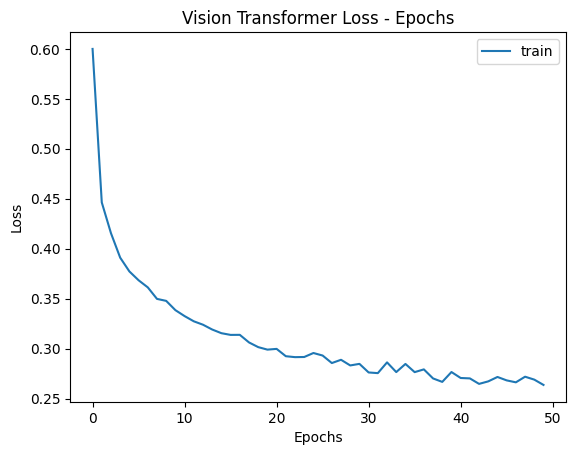

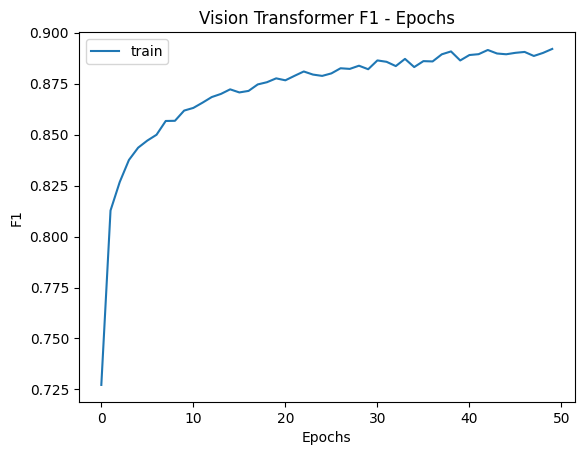

In [67]:
plot_model_metrics(mean_loss_train_Vit,mean_f1_train_Vit,model_name = "Vision Transformer",mode="train")

# CaiT

In [68]:
from random import randrange
import torch
from torch import nn, einsum
#import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# file adapted from: https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/cait.py
# helpers


def exists(val):
    return val is not None


def dropout_layers(layers, dropout):
    if dropout == 0:
        return layers

    num_layers = len(layers)
    to_drop = torch.zeros(num_layers).uniform_(0.0, 1.0) < dropout

    # make sure at least one layer makes it
    if all(to_drop):
        rand_index = randrange(num_layers)
        to_drop[rand_index] = False

    layers = [layer for (layer, drop) in zip(layers, to_drop) if not drop]
    return layers


# classes


class LayerScale(nn.Module):
    def __init__(self, dim, fn, depth):
        super().__init__()
        if depth <= 18:  # epsilon detailed in section 2 of paper
            init_eps = 0.1
        elif depth > 18 and depth <= 24:
            init_eps = 1e-5
        else:
            init_eps = 1e-6

        scale = torch.zeros(1, 1, dim).fill_(init_eps)
        self.scale = nn.Parameter(scale)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) * self.scale


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = dim_head * heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)

        self.attend = nn.Softmax(dim=-1)

        self.mix_heads_pre_attn = nn.Parameter(torch.randn(heads, heads))
        self.mix_heads_post_attn = nn.Parameter(torch.randn(heads, heads))

        self.to_out = nn.Sequential(nn.Linear(inner_dim, dim), nn.Dropout(dropout))

    def forward(self, x, context=None):
        b, n, _, h = *x.shape, self.heads

        context = x if not exists(context) else torch.cat((x, context), dim=1)

        qkv = (self.to_q(x), *self.to_kv(context).chunk(2, dim=-1))
        q, k, v = map(lambda t: rearrange(t, "b n (h d) -> b h n d", h=h), qkv)

        dots = einsum("b h i d, b h j d -> b h i j", q, k) * self.scale

        dots = einsum(
            "b h i j, h g -> b g i j", dots, self.mix_heads_pre_attn
        )  # talking heads, pre-softmax
        attn = self.attend(dots)
        attn = einsum(
            "b h i j, h g -> b g i j", attn, self.mix_heads_post_attn
        )  # talking heads, post-softmax

        out = einsum("b h i j, b h j d -> b h i d", attn, v)
        out = rearrange(out, "b h n d -> b n (h d)")
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(
        self, dim, depth, heads, dim_head, mlp_dim, dropout=0.0, layer_dropout=0.0
    ):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.layer_dropout = layer_dropout

        for ind in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        LayerScale(
                            dim,
                            PreNorm(
                                dim,
                                Attention(
                                    dim, heads=heads, dim_head=dim_head, dropout=dropout
                                ),
                            ),
                            depth=ind + 1,
                        ),
                        LayerScale(
                            dim,
                            PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)),
                            depth=ind + 1,
                        ),
                    ]
                )
            )

    def forward(self, x, context=None):
        layers = dropout_layers(self.layers, dropout=self.layer_dropout)

        for attn, ff in layers:
            x = attn(x, context=context) + x
            x = ff(x) + x
        return x


class CaiT(nn.Module):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        num_classes,
        dim,
        depth,
        cls_depth,
        heads,
        mlp_dim,
        dim_head=64,
        dropout=0.0,
        emb_dropout=0.0,
        layer_dropout=0.0,
        channels=3
    ):
        super().__init__()
        assert (
            image_size % patch_size == 0
        ), "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.to_patch_embedding = nn.Sequential(
            Rearrange(
                "b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_size, p2=patch_size
            ),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))

        self.dropout = nn.Dropout(emb_dropout)

        self.patch_transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout, layer_dropout
        )
        self.cls_transformer = Transformer(
            dim, cls_depth, heads, dim_head, mlp_dim, dropout, layer_dropout
        )

        self.mlp_head = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        x += self.pos_embedding[:, :n]
        x = self.dropout(x)

        x = self.patch_transformer(x)

        cls_tokens = repeat(self.cls_token, "() n d -> b n d", b=b)
        x = self.cls_transformer(cls_tokens, context=x)

        return self.mlp_head(x[:, 0])

In [69]:
cait = CaiT(
    image_size = 64,
    patch_size = 32,
    num_classes = 3,
    channels = 1,
    dim = 1024,
    depth = 2,             # depth of transformer for patch to patch attention only
    cls_depth = 1,          # depth of cross attention of CLS tokens to patch
    heads = 16,
    mlp_dim = 16,
    dropout = 0.1,
    emb_dropout = 0.1,
    layer_dropout = 0.05    # randomly dropout 5% of the layers
)

In [70]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cait.parameters(),lr=1e-4)
cait.to(device)

CaiT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (patch_transformer): Transformer(
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): LayerScale(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_q): Linear(in_features=1024, out_features=1024, bias=False)
              (to_kv): Linear(in_features=1024, out_features=2048, bias=False)
              (attend): Softmax(dim=-1)
              (to_out): Sequential(
                (0): Linear(in_features=1024, out_features=1024, bias=True)
                (1): Dropout(p=0.1, inplace=False)
              )
            )
          )
        )
        (1): LayerScale(
          (fn): PreNorm(
            (norm): LayerNorm((1024,), eps=1e-05, elementwise_aff

In [71]:
mean_loss_train_CaiT,mean_f1_train_CaiT,mean_loss_test_CaiT,mean_f1_test_CaiT = train_final_model_other(cait,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="CaiT")

100%|██████████| 188/188 [00:03<00:00, 51.05it/s]


Epoch 0/50, Train Loss: 0.7540, Train F1: 0.6283,Test Loss: 0.4612, Test F1: 0.7906, bestf1:0.7906


100%|██████████| 188/188 [00:03<00:00, 52.96it/s]


Epoch 1/50, Train Loss: 0.5098, Train F1: 0.7794,Test Loss: 0.5129, Test F1: 0.7766, bestf1:0.7906


100%|██████████| 188/188 [00:03<00:00, 53.10it/s]


Epoch 2/50, Train Loss: 0.4503, Train F1: 0.8079,Test Loss: 0.4581, Test F1: 0.7942, bestf1:0.7942


100%|██████████| 188/188 [00:03<00:00, 54.79it/s]


Epoch 3/50, Train Loss: 0.3931, Train F1: 0.8352,Test Loss: 0.4114, Test F1: 0.8395, bestf1:0.8395


100%|██████████| 188/188 [00:03<00:00, 54.43it/s]


Epoch 4/50, Train Loss: 0.3595, Train F1: 0.8492,Test Loss: 0.3164, Test F1: 0.8606, bestf1:0.8606


100%|██████████| 188/188 [00:03<00:00, 55.06it/s]


Epoch 5/50, Train Loss: 0.4052, Train F1: 0.8367,Test Loss: 0.4247, Test F1: 0.8274, bestf1:0.8606


100%|██████████| 188/188 [00:03<00:00, 54.18it/s]


Epoch 6/50, Train Loss: 0.3546, Train F1: 0.8560,Test Loss: 0.3531, Test F1: 0.8507, bestf1:0.8606


100%|██████████| 188/188 [00:03<00:00, 54.82it/s]


Epoch 7/50, Train Loss: 0.3142, Train F1: 0.8697,Test Loss: 0.3197, Test F1: 0.8657, bestf1:0.8657


100%|██████████| 188/188 [00:03<00:00, 54.09it/s]


Epoch 8/50, Train Loss: 0.2909, Train F1: 0.8780,Test Loss: 0.2890, Test F1: 0.8721, bestf1:0.8721


100%|██████████| 188/188 [00:03<00:00, 54.58it/s]


Epoch 9/50, Train Loss: 0.2821, Train F1: 0.8830,Test Loss: 0.3164, Test F1: 0.8795, bestf1:0.8795


100%|██████████| 188/188 [00:03<00:00, 54.55it/s]


Epoch 10/50, Train Loss: 0.2692, Train F1: 0.8898,Test Loss: 0.2300, Test F1: 0.8999, bestf1:0.8999


100%|██████████| 188/188 [00:03<00:00, 54.80it/s]


Epoch 11/50, Train Loss: 0.2650, Train F1: 0.8909,Test Loss: 0.2261, Test F1: 0.9023, bestf1:0.9023


100%|██████████| 188/188 [00:04<00:00, 46.86it/s]


Epoch 12/50, Train Loss: 0.2508, Train F1: 0.8967,Test Loss: 0.2043, Test F1: 0.9122, bestf1:0.9122


100%|██████████| 188/188 [00:03<00:00, 54.26it/s]


Epoch 13/50, Train Loss: 0.2542, Train F1: 0.8938,Test Loss: 0.2109, Test F1: 0.9054, bestf1:0.9122


100%|██████████| 188/188 [00:03<00:00, 54.20it/s]


Epoch 14/50, Train Loss: 0.2401, Train F1: 0.9013,Test Loss: 0.2070, Test F1: 0.9110, bestf1:0.9122


100%|██████████| 188/188 [00:03<00:00, 52.79it/s]


Epoch 15/50, Train Loss: 0.2434, Train F1: 0.9008,Test Loss: 0.1766, Test F1: 0.9216, bestf1:0.9216


100%|██████████| 188/188 [00:03<00:00, 54.52it/s]


Epoch 16/50, Train Loss: 0.2253, Train F1: 0.9074,Test Loss: 0.1634, Test F1: 0.9210, bestf1:0.9216


100%|██████████| 188/188 [00:03<00:00, 47.98it/s]


Epoch 17/50, Train Loss: 0.2167, Train F1: 0.9117,Test Loss: 0.2008, Test F1: 0.9087, bestf1:0.9216


100%|██████████| 188/188 [00:03<00:00, 53.49it/s]


Epoch 18/50, Train Loss: 0.2192, Train F1: 0.9096,Test Loss: 0.2115, Test F1: 0.9112, bestf1:0.9216


100%|██████████| 188/188 [00:03<00:00, 54.32it/s]


Epoch 19/50, Train Loss: 0.2086, Train F1: 0.9146,Test Loss: 0.1725, Test F1: 0.9225, bestf1:0.9225


100%|██████████| 188/188 [00:03<00:00, 55.10it/s]


Epoch 20/50, Train Loss: 0.2018, Train F1: 0.9187,Test Loss: 0.2178, Test F1: 0.9073, bestf1:0.9225


100%|██████████| 188/188 [00:03<00:00, 52.26it/s]


Epoch 21/50, Train Loss: 0.2289, Train F1: 0.9108,Test Loss: 0.1574, Test F1: 0.9252, bestf1:0.9252


100%|██████████| 188/188 [00:03<00:00, 52.20it/s]


Epoch 22/50, Train Loss: 0.2079, Train F1: 0.9153,Test Loss: 0.1671, Test F1: 0.9268, bestf1:0.9268


100%|██████████| 188/188 [00:03<00:00, 51.81it/s]


Epoch 23/50, Train Loss: 0.2459, Train F1: 0.9035,Test Loss: 0.3411, Test F1: 0.8720, bestf1:0.9268


100%|██████████| 188/188 [00:03<00:00, 49.95it/s]


Epoch 24/50, Train Loss: 0.2887, Train F1: 0.8936,Test Loss: 0.2211, Test F1: 0.9080, bestf1:0.9268


100%|██████████| 188/188 [00:03<00:00, 49.06it/s]


Epoch 25/50, Train Loss: 0.2146, Train F1: 0.9129,Test Loss: 0.1844, Test F1: 0.9353, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 52.08it/s]


Epoch 26/50, Train Loss: 0.2013, Train F1: 0.9182,Test Loss: 0.2035, Test F1: 0.9151, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 52.50it/s]


Epoch 27/50, Train Loss: 0.2013, Train F1: 0.9194,Test Loss: 0.1490, Test F1: 0.9331, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 48.93it/s]


Epoch 28/50, Train Loss: 0.1940, Train F1: 0.9228,Test Loss: 0.1520, Test F1: 0.9334, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 53.17it/s]


Epoch 29/50, Train Loss: 0.1870, Train F1: 0.9249,Test Loss: 0.2216, Test F1: 0.9120, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 52.24it/s]


Epoch 30/50, Train Loss: 0.1853, Train F1: 0.9255,Test Loss: 0.1554, Test F1: 0.9321, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 52.92it/s]


Epoch 31/50, Train Loss: 0.1803, Train F1: 0.9281,Test Loss: 0.2440, Test F1: 0.8832, bestf1:0.9353


100%|██████████| 188/188 [00:03<00:00, 55.83it/s]


Epoch 32/50, Train Loss: 0.1797, Train F1: 0.9286,Test Loss: 0.1648, Test F1: 0.9365, bestf1:0.9365


100%|██████████| 188/188 [00:03<00:00, 55.92it/s]


Epoch 33/50, Train Loss: 0.1824, Train F1: 0.9291,Test Loss: 0.2161, Test F1: 0.9181, bestf1:0.9365


100%|██████████| 188/188 [00:03<00:00, 53.60it/s]


Epoch 34/50, Train Loss: 0.2194, Train F1: 0.9182,Test Loss: 0.1644, Test F1: 0.9356, bestf1:0.9365


100%|██████████| 188/188 [00:03<00:00, 54.34it/s]


Epoch 35/50, Train Loss: 0.1774, Train F1: 0.9287,Test Loss: 0.1472, Test F1: 0.9373, bestf1:0.9373


100%|██████████| 188/188 [00:04<00:00, 45.77it/s]


Epoch 36/50, Train Loss: 0.1736, Train F1: 0.9319,Test Loss: 0.1602, Test F1: 0.9293, bestf1:0.9373


100%|██████████| 188/188 [00:03<00:00, 53.94it/s]


Epoch 37/50, Train Loss: 0.1710, Train F1: 0.9328,Test Loss: 0.1481, Test F1: 0.9403, bestf1:0.9403


100%|██████████| 188/188 [00:03<00:00, 54.08it/s]


Epoch 38/50, Train Loss: 0.1684, Train F1: 0.9346,Test Loss: 0.3529, Test F1: 0.8488, bestf1:0.9403


100%|██████████| 188/188 [00:03<00:00, 50.95it/s]


Epoch 39/50, Train Loss: 0.2003, Train F1: 0.9219,Test Loss: 0.1188, Test F1: 0.9508, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 50.79it/s]


Epoch 40/50, Train Loss: 0.1961, Train F1: 0.9245,Test Loss: 0.1349, Test F1: 0.9422, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 53.63it/s]


Epoch 41/50, Train Loss: 0.1784, Train F1: 0.9302,Test Loss: 0.1919, Test F1: 0.9268, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 52.10it/s]


Epoch 42/50, Train Loss: 0.1716, Train F1: 0.9325,Test Loss: 0.1453, Test F1: 0.9349, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 51.44it/s]


Epoch 43/50, Train Loss: 0.1646, Train F1: 0.9365,Test Loss: 0.1908, Test F1: 0.9261, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 50.69it/s]


Epoch 44/50, Train Loss: 0.1592, Train F1: 0.9382,Test Loss: 0.1215, Test F1: 0.9463, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 52.32it/s]


Epoch 45/50, Train Loss: 0.1625, Train F1: 0.9368,Test Loss: 0.1833, Test F1: 0.9456, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 51.32it/s]


Epoch 46/50, Train Loss: 0.1661, Train F1: 0.9361,Test Loss: 0.1490, Test F1: 0.9346, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 52.37it/s]


Epoch 47/50, Train Loss: 0.1620, Train F1: 0.9380,Test Loss: 0.2028, Test F1: 0.9221, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 49.58it/s]


Epoch 48/50, Train Loss: 0.1558, Train F1: 0.9399,Test Loss: 0.1304, Test F1: 0.9409, bestf1:0.9508


100%|██████████| 188/188 [00:03<00:00, 51.49it/s]


Epoch 49/50, Train Loss: 0.1602, Train F1: 0.9382,Test Loss: 0.1404, Test F1: 0.9438, bestf1:0.9508


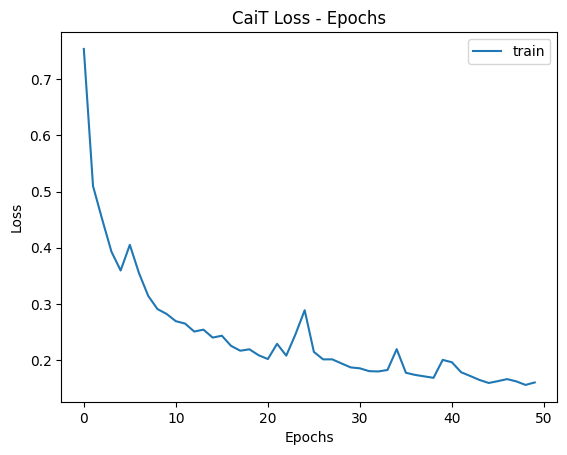

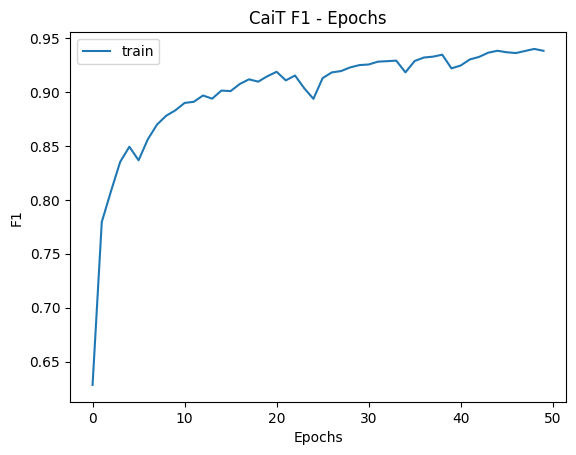

In [72]:
plot_model_metrics(mean_loss_train_CaiT,mean_f1_train_CaiT,model_name = "CaiT",mode="train")

# Vision Transformer for Small Dataset

In [73]:
from math import sqrt
import torch
import torch.nn.functional as F2
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class LSA(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.temperature = nn.Parameter(torch.log(torch.tensor(dim_head ** -0.5)))

        self.norm = nn.LayerNorm(dim)
        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.temperature.exp()

        mask = torch.eye(dots.shape[-1], device = dots.device, dtype = torch.bool)
        mask_value = -torch.finfo(dots.dtype).max
        dots = dots.masked_fill(mask, mask_value)

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                LSA(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class SPT(nn.Module):
    def __init__(self, *, dim, patch_size, channels = 3):
        super().__init__()
        patch_dim = patch_size * patch_size * 5 * channels

        self.to_patch_tokens = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim)
        )

    def forward(self, x):
        shifts = ((1, -1, 0, 0), (-1, 1, 0, 0), (0, 0, 1, -1), (0, 0, -1, 1))
        shifted_x = list(map(lambda shift: F2.pad(x, shift), shifts))
        x_with_shifts = torch.cat((x, *shifted_x), dim = 1)
        return self.to_patch_tokens(x_with_shifts)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = SPT(dim = dim, patch_size = patch_size, channels = channels)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [74]:
vitsd = ViT(image_size=64,
            patch_size=32,
            num_classes=3,
            dim=1024,
            depth=2,
            heads=16,
            mlp_dim=16,
            channels = 1,
            dropout = 0.1,
            emb_dropout = 0.1)

In [75]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vitsd.parameters(),lr=1e-4)
vitsd.to(device)

ViT(
  (to_patch_embedding): SPT(
    (to_patch_tokens): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=5120, out_features=1024, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): LSA(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1024, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_fea

In [76]:
mean_loss_train_VitSD,mean_f1_train_VitSD,mean_loss_test_VitSD,mean_f1_test_VitSD = train_final_model_other(vitsd,train_looader,test_looader,n_epochs=CONFIG.epochs,optimizer=optimizer,criterion=criterion,device=device,model_name="VITSD")

100%|██████████| 188/188 [00:03<00:00, 55.27it/s]


Epoch 0/50, Train Loss: 0.5995, Train F1: 0.7254,Test Loss: 0.3688, Test F1: 0.8572, bestf1:0.8572


100%|██████████| 188/188 [00:03<00:00, 55.14it/s]


Epoch 1/50, Train Loss: 0.4393, Train F1: 0.8149,Test Loss: 0.5131, Test F1: 0.7978, bestf1:0.8572


100%|██████████| 188/188 [00:03<00:00, 49.26it/s]


Epoch 2/50, Train Loss: 0.4048, Train F1: 0.8307,Test Loss: 0.4063, Test F1: 0.8411, bestf1:0.8572


100%|██████████| 188/188 [00:03<00:00, 54.10it/s]


Epoch 3/50, Train Loss: 0.3887, Train F1: 0.8389,Test Loss: 0.4765, Test F1: 0.8160, bestf1:0.8572


100%|██████████| 188/188 [00:03<00:00, 55.48it/s]


Epoch 4/50, Train Loss: 0.3691, Train F1: 0.8467,Test Loss: 0.4223, Test F1: 0.8316, bestf1:0.8572


100%|██████████| 188/188 [00:03<00:00, 54.52it/s]


Epoch 5/50, Train Loss: 0.3619, Train F1: 0.8512,Test Loss: 0.3672, Test F1: 0.8501, bestf1:0.8572


100%|██████████| 188/188 [00:03<00:00, 54.20it/s]


Epoch 6/50, Train Loss: 0.3563, Train F1: 0.8523,Test Loss: 0.3123, Test F1: 0.8694, bestf1:0.8694


100%|██████████| 188/188 [00:03<00:00, 54.51it/s]


Epoch 7/50, Train Loss: 0.3485, Train F1: 0.8555,Test Loss: 0.3693, Test F1: 0.8505, bestf1:0.8694


100%|██████████| 188/188 [00:03<00:00, 54.03it/s]


Epoch 8/50, Train Loss: 0.3405, Train F1: 0.8592,Test Loss: 0.3823, Test F1: 0.8439, bestf1:0.8694


100%|██████████| 188/188 [00:03<00:00, 54.16it/s]


Epoch 9/50, Train Loss: 0.3317, Train F1: 0.8645,Test Loss: 0.3136, Test F1: 0.8708, bestf1:0.8708


100%|██████████| 188/188 [00:03<00:00, 56.04it/s]


Epoch 10/50, Train Loss: 0.3330, Train F1: 0.8630,Test Loss: 0.3175, Test F1: 0.8666, bestf1:0.8708


100%|██████████| 188/188 [00:03<00:00, 56.07it/s]


Epoch 11/50, Train Loss: 0.3292, Train F1: 0.8643,Test Loss: 0.3448, Test F1: 0.8675, bestf1:0.8708


100%|██████████| 188/188 [00:04<00:00, 46.03it/s]


Epoch 12/50, Train Loss: 0.3202, Train F1: 0.8682,Test Loss: 0.2989, Test F1: 0.8758, bestf1:0.8758


100%|██████████| 188/188 [00:03<00:00, 55.18it/s]


Epoch 13/50, Train Loss: 0.3254, Train F1: 0.8661,Test Loss: 0.3674, Test F1: 0.8611, bestf1:0.8758


100%|██████████| 188/188 [00:03<00:00, 55.27it/s]


Epoch 14/50, Train Loss: 0.3131, Train F1: 0.8698,Test Loss: 0.2852, Test F1: 0.8847, bestf1:0.8847


100%|██████████| 188/188 [00:03<00:00, 53.39it/s]


Epoch 15/50, Train Loss: 0.3066, Train F1: 0.8729,Test Loss: 0.2852, Test F1: 0.8831, bestf1:0.8847


100%|██████████| 188/188 [00:03<00:00, 53.63it/s]


Epoch 16/50, Train Loss: 0.3084, Train F1: 0.8735,Test Loss: 0.3249, Test F1: 0.8732, bestf1:0.8847


100%|██████████| 188/188 [00:03<00:00, 52.30it/s]


Epoch 17/50, Train Loss: 0.3072, Train F1: 0.8736,Test Loss: 0.2896, Test F1: 0.8811, bestf1:0.8847


100%|██████████| 188/188 [00:03<00:00, 54.37it/s]


Epoch 18/50, Train Loss: 0.3025, Train F1: 0.8754,Test Loss: 0.2928, Test F1: 0.8846, bestf1:0.8847


100%|██████████| 188/188 [00:03<00:00, 53.63it/s]


Epoch 19/50, Train Loss: 0.3027, Train F1: 0.8757,Test Loss: 0.2903, Test F1: 0.8760, bestf1:0.8847


100%|██████████| 188/188 [00:03<00:00, 56.21it/s]


Epoch 20/50, Train Loss: 0.2987, Train F1: 0.8761,Test Loss: 0.2634, Test F1: 0.8928, bestf1:0.8928


100%|██████████| 188/188 [00:03<00:00, 55.45it/s]


Epoch 21/50, Train Loss: 0.2961, Train F1: 0.8784,Test Loss: 0.2915, Test F1: 0.8826, bestf1:0.8928


100%|██████████| 188/188 [00:03<00:00, 56.23it/s]


Epoch 22/50, Train Loss: 0.2951, Train F1: 0.8782,Test Loss: 0.2777, Test F1: 0.8860, bestf1:0.8928


100%|██████████| 188/188 [00:03<00:00, 56.12it/s]


Epoch 23/50, Train Loss: 0.2891, Train F1: 0.8818,Test Loss: 0.3194, Test F1: 0.8767, bestf1:0.8928


100%|██████████| 188/188 [00:03<00:00, 51.63it/s]


Epoch 24/50, Train Loss: 0.2855, Train F1: 0.8815,Test Loss: 0.2624, Test F1: 0.8942, bestf1:0.8942


100%|██████████| 188/188 [00:03<00:00, 47.11it/s]


Epoch 25/50, Train Loss: 0.2868, Train F1: 0.8823,Test Loss: 0.2823, Test F1: 0.8865, bestf1:0.8942


100%|██████████| 188/188 [00:03<00:00, 55.63it/s]


Epoch 26/50, Train Loss: 0.2798, Train F1: 0.8846,Test Loss: 0.2874, Test F1: 0.8889, bestf1:0.8942


100%|██████████| 188/188 [00:03<00:00, 57.48it/s]


Epoch 27/50, Train Loss: 0.2850, Train F1: 0.8831,Test Loss: 0.2979, Test F1: 0.8838, bestf1:0.8942


100%|██████████| 188/188 [00:03<00:00, 53.91it/s]


Epoch 28/50, Train Loss: 0.2795, Train F1: 0.8863,Test Loss: 0.2539, Test F1: 0.8951, bestf1:0.8951


100%|██████████| 188/188 [00:03<00:00, 54.64it/s]


Epoch 29/50, Train Loss: 0.2819, Train F1: 0.8842,Test Loss: 0.3445, Test F1: 0.8752, bestf1:0.8951


100%|██████████| 188/188 [00:03<00:00, 57.90it/s]


Epoch 30/50, Train Loss: 0.2784, Train F1: 0.8852,Test Loss: 0.2677, Test F1: 0.8917, bestf1:0.8951


100%|██████████| 188/188 [00:03<00:00, 56.77it/s]


Epoch 31/50, Train Loss: 0.2687, Train F1: 0.8885,Test Loss: 0.2551, Test F1: 0.8959, bestf1:0.8959


100%|██████████| 188/188 [00:03<00:00, 57.20it/s]


Epoch 32/50, Train Loss: 0.2730, Train F1: 0.8875,Test Loss: 0.2396, Test F1: 0.9031, bestf1:0.9031


100%|██████████| 188/188 [00:03<00:00, 52.62it/s]


Epoch 33/50, Train Loss: 0.2690, Train F1: 0.8894,Test Loss: 0.2287, Test F1: 0.9030, bestf1:0.9031


100%|██████████| 188/188 [00:03<00:00, 56.47it/s]


Epoch 34/50, Train Loss: 0.2740, Train F1: 0.8880,Test Loss: 0.2283, Test F1: 0.9045, bestf1:0.9045


100%|██████████| 188/188 [00:03<00:00, 55.08it/s]


Epoch 35/50, Train Loss: 0.2687, Train F1: 0.8894,Test Loss: 0.2482, Test F1: 0.8959, bestf1:0.9045


100%|██████████| 188/188 [00:03<00:00, 57.23it/s]


Epoch 36/50, Train Loss: 0.2654, Train F1: 0.8906,Test Loss: 0.2588, Test F1: 0.8965, bestf1:0.9045


100%|██████████| 188/188 [00:03<00:00, 55.09it/s]


Epoch 37/50, Train Loss: 0.2619, Train F1: 0.8922,Test Loss: 0.2775, Test F1: 0.8916, bestf1:0.9045


100%|██████████| 188/188 [00:03<00:00, 55.59it/s]


Epoch 38/50, Train Loss: 0.2619, Train F1: 0.8927,Test Loss: 0.2265, Test F1: 0.9073, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 58.50it/s]


Epoch 39/50, Train Loss: 0.2599, Train F1: 0.8924,Test Loss: 0.2333, Test F1: 0.9049, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 57.01it/s]


Epoch 40/50, Train Loss: 0.2588, Train F1: 0.8931,Test Loss: 0.2501, Test F1: 0.9004, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 56.61it/s]


Epoch 41/50, Train Loss: 0.2569, Train F1: 0.8948,Test Loss: 0.2373, Test F1: 0.9019, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 55.80it/s]


Epoch 42/50, Train Loss: 0.2559, Train F1: 0.8939,Test Loss: 0.2338, Test F1: 0.9008, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 56.92it/s]


Epoch 43/50, Train Loss: 0.2554, Train F1: 0.8945,Test Loss: 0.2597, Test F1: 0.8979, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 55.45it/s]


Epoch 44/50, Train Loss: 0.2548, Train F1: 0.8962,Test Loss: 0.2620, Test F1: 0.8969, bestf1:0.9073


100%|██████████| 188/188 [00:03<00:00, 54.60it/s]


Epoch 45/50, Train Loss: 0.2539, Train F1: 0.8958,Test Loss: 0.2227, Test F1: 0.9080, bestf1:0.9080


100%|██████████| 188/188 [00:03<00:00, 56.93it/s]


Epoch 46/50, Train Loss: 0.2500, Train F1: 0.8979,Test Loss: 0.2512, Test F1: 0.8993, bestf1:0.9080


100%|██████████| 188/188 [00:03<00:00, 55.33it/s]


Epoch 47/50, Train Loss: 0.2457, Train F1: 0.8976,Test Loss: 0.2411, Test F1: 0.9022, bestf1:0.9080


100%|██████████| 188/188 [00:03<00:00, 56.24it/s]


Epoch 48/50, Train Loss: 0.2521, Train F1: 0.8957,Test Loss: 0.2207, Test F1: 0.9098, bestf1:0.9098


100%|██████████| 188/188 [00:03<00:00, 54.47it/s]

Epoch 49/50, Train Loss: 0.2475, Train F1: 0.8986,Test Loss: 0.2311, Test F1: 0.9055, bestf1:0.9098


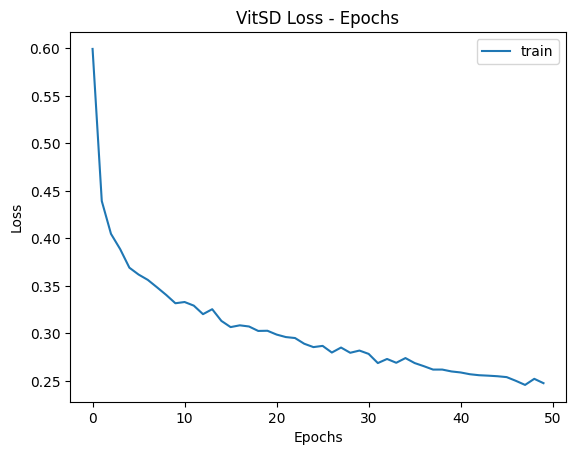

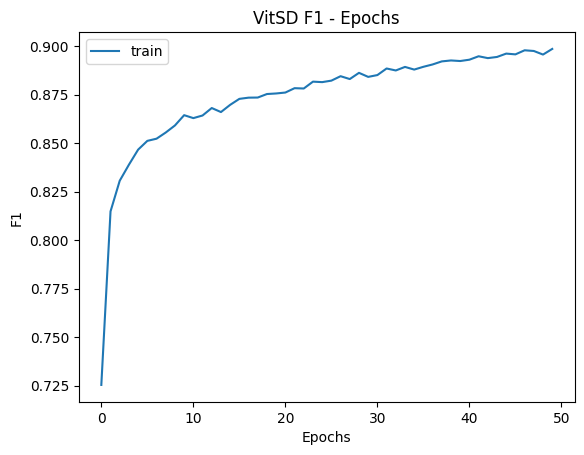

In [77]:
plot_model_metrics(mean_loss_train_VitSD,mean_f1_train_VitSD,model_name = "VitSD",mode="train")

In [78]:
resnet.load_state_dict(torch.load("/kaggle/working/resnet_best.pth"))
vitsd.load_state_dict(torch.load("/kaggle/working/VITSD_best.pth"))
cait.load_state_dict(torch.load("/kaggle/working/CaiT_best.pth"))
ViTr.load_state_dict(torch.load("/kaggle/working/Vision Transformer_best.pth"))
lens.load_state_dict(torch.load("/kaggle/working/Lensformer_best.pth"))
model_small.load_state_dict(torch.load("/kaggle/working/new_model_best.pth"))
model_large.load_state_dict(torch.load("/kaggle/working/LensPINN_large_best.pth"))

<All keys matched successfully>

In [79]:
def plot_model_metrics_saath(mean_loss_train_list, mean_f1_train_list, name_list,mode):
    """
    Plots the training loss and F1 score over epochs.

    Args:
        mean_loss_train_list (list): List of mean training loss over epochs for different models.
        mean_f1_train_list (list): List of mean training F1 scores over epochs for different models.
        name_list (list): List of names for the different models.

    Returns:
        None
    """
    # Plot training loss over epochs
    plt.figure(figsize=(8, 6))
    for i in range(len(mean_loss_train_list)):
        plt.plot(mean_loss_train_list[i], label=f'{name_list[i]} - Loss')
    plt.title(mode+' Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training F1 score over epochs
    plt.figure(figsize=(8, 6))
    for i in range(len(mean_f1_train_list)):
        plt.plot(mean_f1_train_list[i], label=f'{name_list[i]} - F1 Score')
    plt.title(mode+' F1 Score - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [80]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.style.use('default')

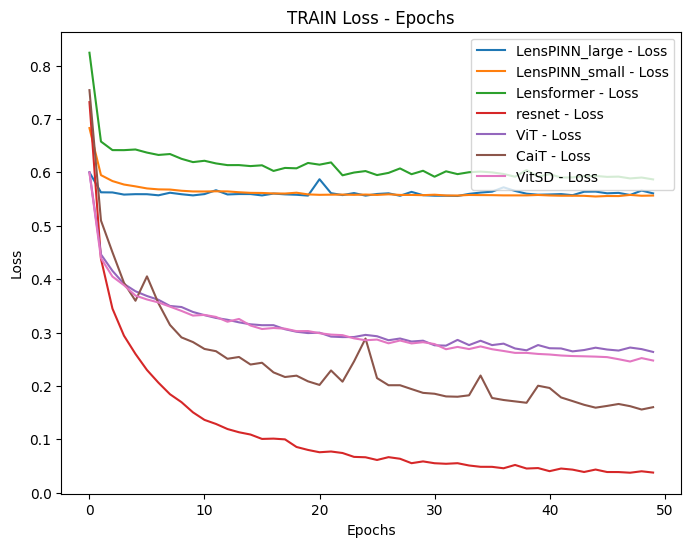

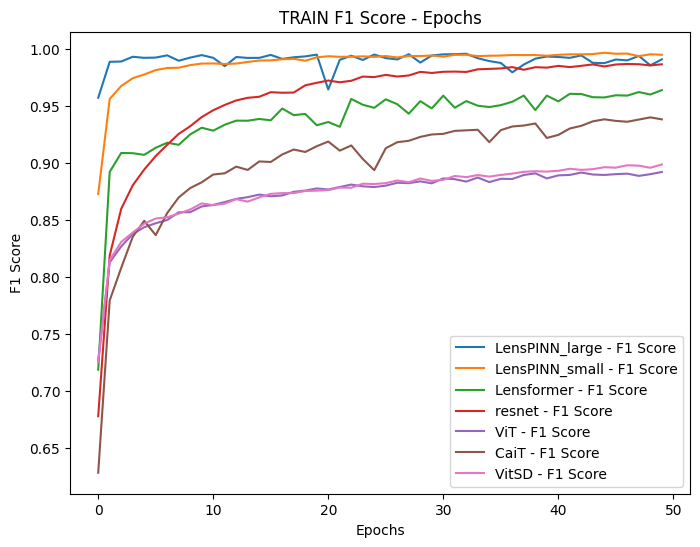

In [81]:
plot_model_metrics_saath([mean_loss_train_LensPINN_large,
                          mean_loss_train_LensPINN_small,
                          mean_loss_train_lens,
                          mean_loss_train_resnet,
                          mean_loss_train_Vit,
                          mean_loss_train_CaiT,
                          mean_loss_train_VitSD],
                         [mean_f1_train_LensPINN_large,
                          mean_f1_train_LensPINN_small,
                          mean_f1_train_lens,
                          mean_f1_train_resnet,
                          mean_f1_train_Vit,
                          mean_f1_train_CaiT,
                          mean_f1_train_VitSD],["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"],mode = "TRAIN")

performance on test data


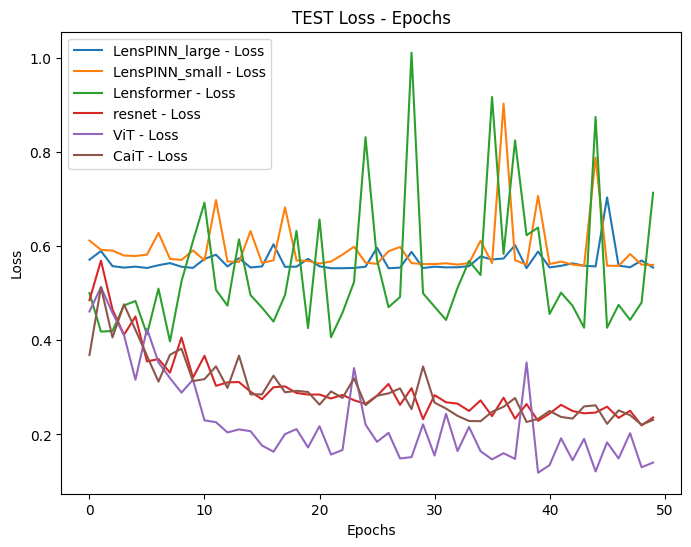

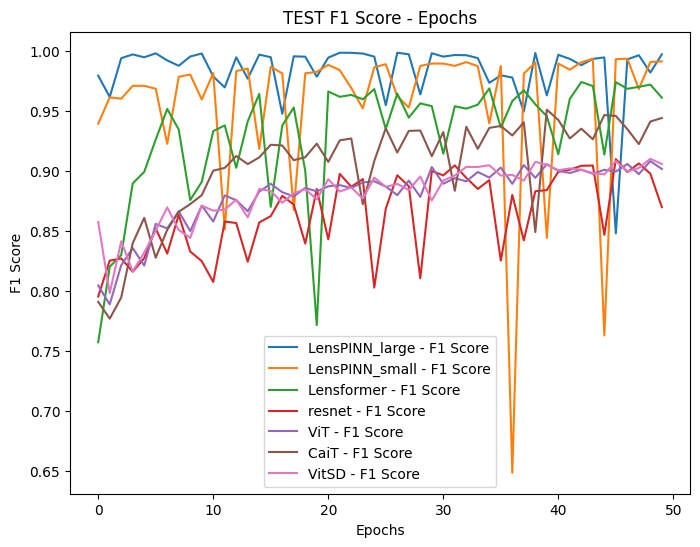

In [82]:
print("performance on test data")
plot_model_metrics_saath([mean_loss_test_LensPINN_large,
                          mean_loss_test_LensPINN_small,
                          mean_loss_test_resnet,
                          mean_loss_test_Vit,
                          mean_loss_test_CaiT,
                          mean_loss_test_VitSD],
                         [mean_f1_test_LensPINN_large,
                          mean_f1_test_LensPINN_small,
                          mean_f1_test_lens,
                          mean_f1_test_resnet,
                          mean_f1_test_Vit,
                          mean_f1_test_CaiT,
                          mean_f1_test_VitSD],["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"],mode = "TEST")

In [83]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder

In [84]:
one = OneHotEncoder()

# roc curve

In [85]:
from sklearn.metrics import roc_auc_score

def tester(model, test_loader, name,device):
    model.eval()
    iteration_loss = 0
    counter = 0
    correct_predictions = 0
    y_true = []
    y_scores = []

    for images, dis, targets in tqdm(test_loader):
        batch = images.shape[0]
        images = images.view(batch,1,64,64)
        images = images.to("cuda")
        targets = targets.to("cuda")
        dis = dis.to("cuda")
        with torch.no_grad():
            if name not in ["LensPINN_small","LensPINN_large","Lensformer"]:
                out = model(images)
            else:
                _, _, out = model(images, dis)
            
            predicted_classes = torch.argmax(out, dim=1)
            correct_predictions += (predicted_classes == targets).sum().item()
            
            # Append the labels and probabilities to the list
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(out.cpu().numpy())  # Probabilities for each class

        counter += images.shape[0]

    accuracy = correct_predictions / counter
    print("Accuracy:", accuracy)
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)
    
    # calculating ROC AUC 
    roc_auc_scores = []
    false_positive_rate = dict()
    true_positive_rate = dict()
    for i in range(y_scores.shape[1]):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc_scores.append(roc_auc_score(y_true == i, y_scores[:, i]))

    # calcuating average ROC AUC across all the classes by one vs all method and taking mean of the 3 classes
    roc_score = np.mean(roc_auc_scores)
    print("ROC AUC Score:", roc_score)
    
    plt.figure(figsize=(8, 6))
    class_dict = {0:"axion",1:"cdm",2:"no_sub"}
    for i in range(y_scores.shape[1]):
        plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'Class {class_dict[i]} (ROC AUC = {roc_auc_scores[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for '+str(name) )
    plt.legend(loc="lower right")
    plt.show()
    
    return iteration_loss / counter


In [86]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

def tester(model, test_loader, name, device):
    model.eval()
    iteration_loss = 0
    counter = 0
    correct_predictions = 0
    y_true = []
    y_scores = []

    num_classes = 3  # Assuming three classes: axion, cdm, no_sub

    for images, dis, targets in tqdm(test_loader):
        batch = images.shape[0]
        images = images.view(batch, 1, 64, 64)
        images = images.to(device)
        targets = targets.to(device)
        dis = dis.to(device)
        
        with torch.no_grad():
            if name not in ["LensPINN_small", "LensPINN_large", "Lensformer"]:
                out = model(images)
            else:
                _, _, out = model(images, dis)

            predicted_classes = torch.argmax(out, dim=1)
            correct_predictions += (predicted_classes == targets).sum().item()
            
            # Append the labels and probabilities to the list
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(out.cpu().numpy())  # Probabilities for each class

        counter += images.shape[0]

    accuracy = correct_predictions / counter
    print("Accuracy:", accuracy)
    
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Binarize the true labels for multiclass ROC AUC (One-vs-Rest)
    y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  # Assuming classes are 0, 1, 2 (axion, cdm, no_sub)
    
    # Calculate ROC AUC for each class
    roc_auc_scores = []
    false_positive_rate = dict()
    true_positive_rate = dict()
    
    for i in range(num_classes):
        false_positive_rate[i], true_positive_rate[i], _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
        roc_auc_scores.append(roc_auc_score(y_true_binarized[:, i], y_scores[:, i]))

    # Calculate micro-average ROC curve and ROC AUC (flattened binary true and predicted values)
    false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(y_true_binarized.ravel(), y_scores.ravel())
    roc_auc_micro = roc_auc_score(y_true_binarized, y_scores, average="micro")
    
    # Calculate macro-average ROC AUC
    roc_auc_macro = roc_auc_score(y_true_binarized, y_scores, average="macro")
    
    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    class_dict = {0: "axion", 1: "cdm", 2: "no_sub"}
    
    for i in range(num_classes):
        plt.plot(false_positive_rate[i], true_positive_rate[i], label=f'Class {class_dict[i]} (ROC AUC = {roc_auc_scores[i]:.2f})')
    
    # Plot micro-average ROC curve
    plt.plot(false_positive_rate["micro"], true_positive_rate["micro"], 
             label=f'Micro-average ROC curve (ROC AUC = {roc_auc_micro:.2f})', color='deeppink', linestyle=':', linewidth=4)
    
    # Plot macro-average ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for ' + str(name))
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"ROC AUC (Micro-average): {roc_auc_micro}")
    print(f"ROC AUC (Macro-average): {roc_auc_macro}")

    return iteration_loss / counter


100%|██████████| 188/188 [00:03<00:00, 50.39it/s]


Accuracy: 0.9095908674277143


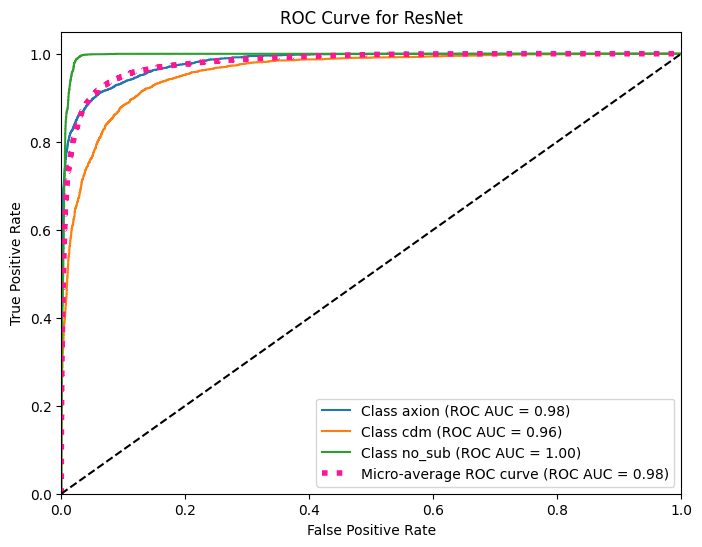

ROC AUC (Micro-average): 0.9790298354508288
ROC AUC (Macro-average): 0.9780030430120684


0.0

In [87]:
tester(resnet,test_looader,"ResNet","cuda")

100%|██████████| 188/188 [00:03<00:00, 50.24it/s]


Accuracy: 0.9097575202066495


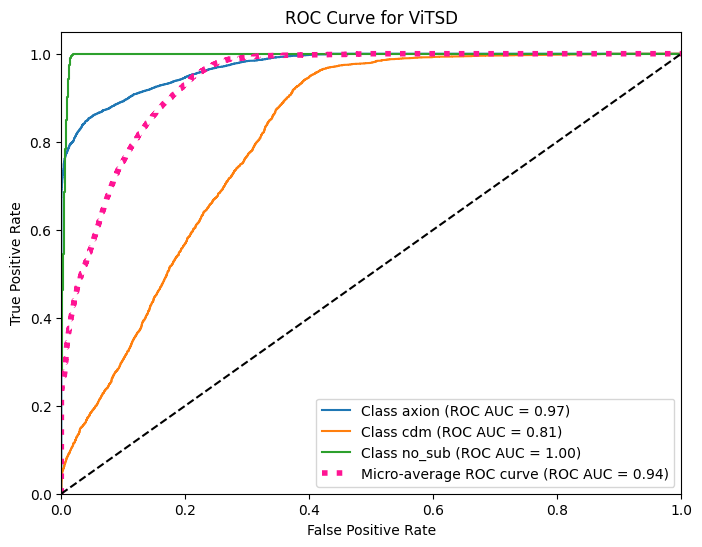

ROC AUC (Micro-average): 0.9377312327269675
ROC AUC (Macro-average): 0.926658293803227


0.0

In [88]:
tester(vitsd,test_looader,"ViTSD","cuda")

100%|██████████| 188/188 [00:03<00:00, 57.76it/s]


Accuracy: 0.9500874927089409


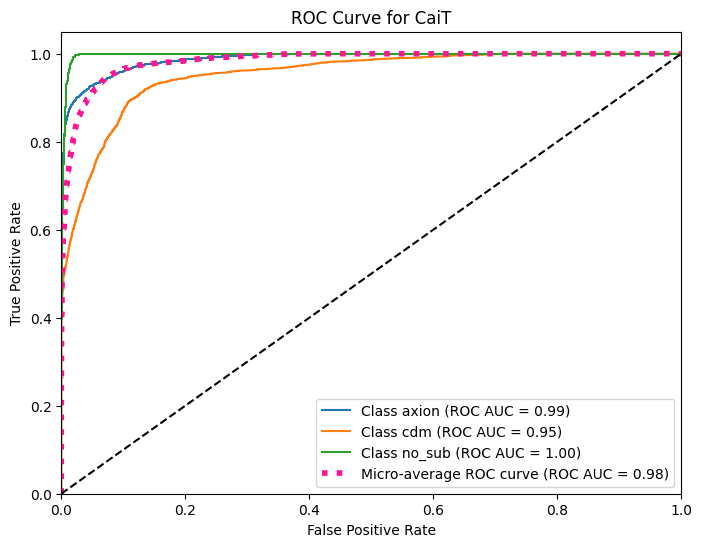

ROC AUC (Micro-average): 0.9835569489560286
ROC AUC (Macro-average): 0.9791684058851228


0.0

In [89]:
tester(cait,test_looader,"CaiT","cuda")

100%|██████████| 188/188 [00:03<00:00, 55.43it/s]


Accuracy: 0.9079243396383635


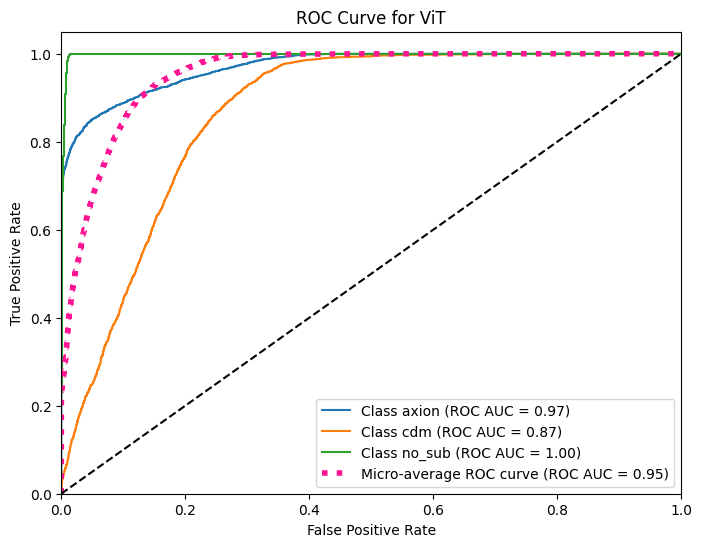

ROC AUC (Micro-average): 0.9534925900996184
ROC AUC (Macro-average): 0.9448887768368986


0.0

In [90]:
tester(ViTr,test_looader,"ViT","cuda")

100%|██████████| 188/188 [00:12<00:00, 14.48it/s]


Accuracy: 0.973835513707191


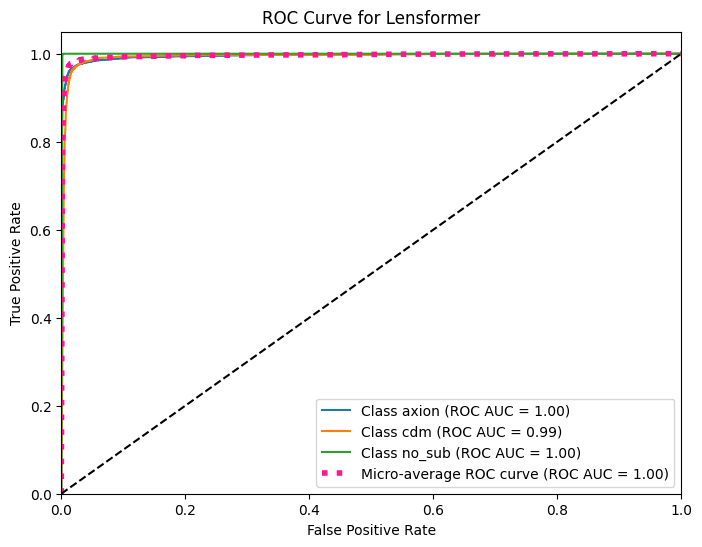

ROC AUC (Micro-average): 0.9954131377727801
ROC AUC (Macro-average): 0.9959272270575789


0.0

In [91]:
tester(lens,test_looader,"Lensformer","cuda")

100%|██████████| 188/188 [00:15<00:00, 11.89it/s]


Accuracy: 0.9933338888425964


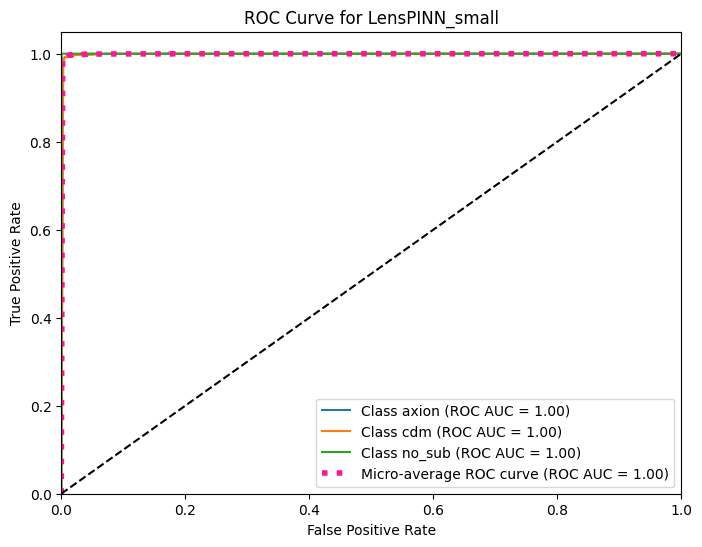

ROC AUC (Micro-average): 0.9987528623788198
ROC AUC (Macro-average): 0.998800435546312


0.0

In [92]:
tester(model_small,test_looader,"LensPINN_small","cuda")

100%|██████████| 188/188 [00:18<00:00, 10.34it/s]


Accuracy: 0.9982501458211815


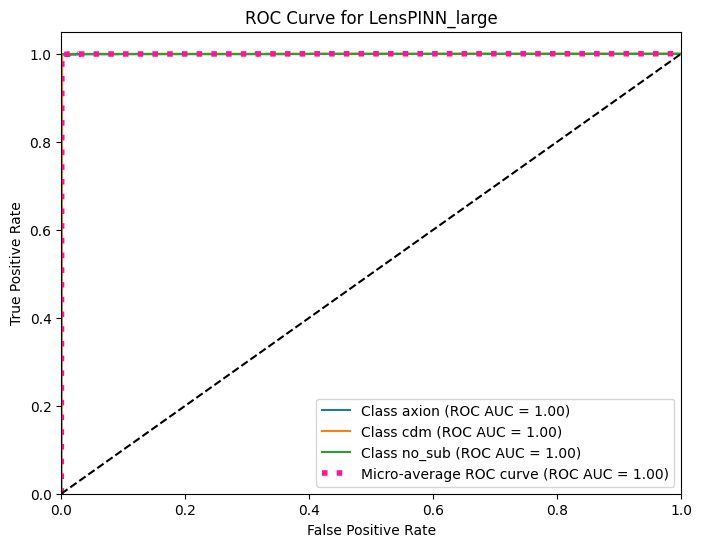

ROC AUC (Micro-average): 0.9993819311407686
ROC AUC (Macro-average): 0.9993920798852544


0.0

In [93]:
tester(model_large,test_looader,"LensPINN_large","cuda")

In [94]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

def tester_together(models, modelnames, test_loader, device, avg_type="micro"):
    """
    Function to evaluate multiple models and plot their micro or macro average ROC curve.

    Args:
    models: list of PyTorch models to evaluate.
    modelnames: list of names corresponding to each model.
    test_loader: DataLoader for test data.
    device: Device to run the models on ("cuda" or "cpu").
    avg_type: "micro" or "macro" to specify the type of average for ROC curve.
    """
    
    assert avg_type in ["micro", "macro"], "avg_type must be either 'micro' or 'macro'"
    
    plt.figure(figsize=(8, 6))
    
    num_classes = 3  # Assuming three classes: axion, cdm, no_sub
    class_dict = {0: "axion", 1: "cdm", 2: "no_sub"}

    for idx in range(len(models)):
        model = models[idx]
        name = modelnames[idx]
        model.eval()
        correct_predictions = 0
        y_true = []
        y_scores = []

        for images, dis, targets in tqdm(test_loader):
            batch = images.shape[0]
            images = images.view(batch, 1, 64, 64)
            images = images.to(device)
            targets = targets.to(device)
            dis = dis.to(device)

            with torch.no_grad():
                if name not in ["LensPINN_small", "LensPINN_large", "Lensformer"]:
                    out = model(images)
                else:
                    _, _, out = model(images, dis)

                predicted_classes = torch.argmax(out, dim=1)
                correct_predictions += (predicted_classes == targets).sum().item()

                # Append the labels and probabilities to the list
                y_true.extend(targets.cpu().numpy())
                y_scores.extend(out.cpu().numpy())  # Probabilities for each class

        accuracy = correct_predictions / len(test_loader.dataset)
        print(f"Accuracy for {name}: {accuracy}")

        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

        # Binarize the true labels for multiclass ROC AUC (One-vs-Rest)
        y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  # Assuming classes are 0, 1, 2

        # Calculate the specified average ROC curve and ROC AUC (micro or macro)
        if avg_type == "micro":
            false_positive_rate, true_positive_rate, _ = roc_curve(y_true_binarized.ravel(), y_scores.ravel())
            roc_auc_avg = roc_auc_score(y_true_binarized, y_scores, average="micro")
        elif avg_type == "macro":
            # For macro, compute the ROC curve for each class and average the results
            false_positive_rate = dict()
            true_positive_rate = dict()
            all_fpr = np.unique(np.concatenate([roc_curve(y_true_binarized[:, i], y_scores[:, i])[0] for i in range(num_classes)]))

            mean_tpr = np.zeros_like(all_fpr)
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
                mean_tpr += np.interp(all_fpr, fpr, tpr)
            mean_tpr /= num_classes

            roc_auc_avg = roc_auc_score(y_true_binarized, y_scores, average="macro")
            false_positive_rate = all_fpr
            true_positive_rate = mean_tpr

        # Plot the ROC curve
        plt.plot(false_positive_rate, true_positive_rate, 
                 label=f'{name} ({avg_type.capitalize()} ROC AUC = {roc_auc_avg:.2f})')

    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{avg_type.capitalize()}-average ROC Curve')
    plt.legend(loc="lower right")
    plt.show()


100%|██████████| 188/188 [00:17<00:00, 10.73it/s]


Accuracy for LensPINN_large: 0.9982501458211815


100%|██████████| 188/188 [00:15<00:00, 11.94it/s]


Accuracy for LensPINN_small: 0.9933338888425964


100%|██████████| 188/188 [00:12<00:00, 14.71it/s]


Accuracy for Lensformer: 0.973835513707191


100%|██████████| 188/188 [00:03<00:00, 52.37it/s]


Accuracy for resnet: 0.9095908674277143


100%|██████████| 188/188 [00:02<00:00, 63.06it/s]


Accuracy for ViT: 0.9079243396383635


100%|██████████| 188/188 [00:03<00:00, 48.42it/s]


Accuracy for CaiT: 0.9500041663194734


100%|██████████| 188/188 [00:02<00:00, 63.27it/s]


Accuracy for VitSD: 0.9097575202066495


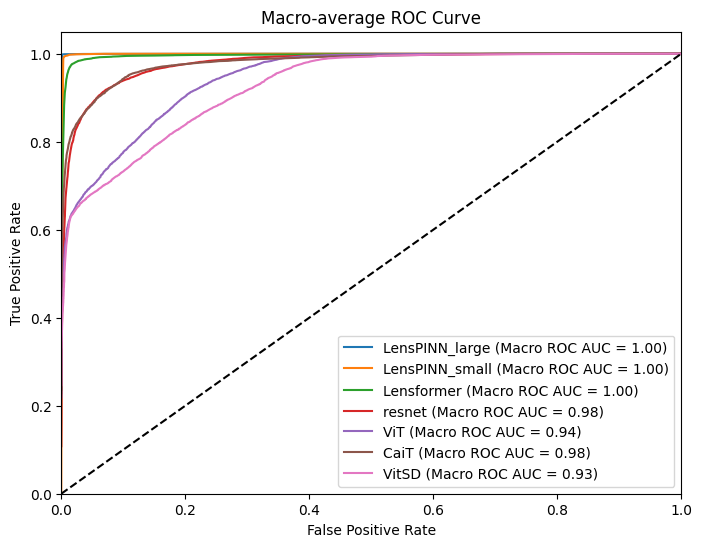

In [95]:
tester_together([model_large,model_small,lens,resnet,ViTr,cait,vitsd], ["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"],test_looader,"cuda","macro")

100%|██████████| 188/188 [00:17<00:00, 10.56it/s]


Accuracy for LensPINN_large: 0.9982501458211815


100%|██████████| 188/188 [00:15<00:00, 12.11it/s]


Accuracy for LensPINN_small: 0.9933338888425964


100%|██████████| 188/188 [00:12<00:00, 14.58it/s]


Accuracy for Lensformer: 0.973835513707191


100%|██████████| 188/188 [00:03<00:00, 52.37it/s]


Accuracy for resnet: 0.9095908674277143


100%|██████████| 188/188 [00:02<00:00, 66.09it/s]


Accuracy for ViT: 0.9079243396383635


100%|██████████| 188/188 [00:03<00:00, 58.22it/s]


Accuracy for CaiT: 0.9507541038246813


100%|██████████| 188/188 [00:02<00:00, 66.00it/s]


Accuracy for VitSD: 0.9097575202066495


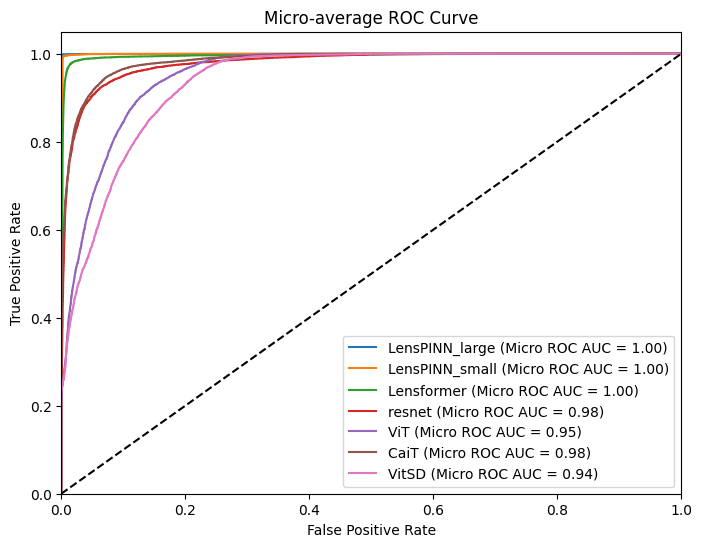

In [96]:
tester_together([model_large,model_small,lens,resnet,ViTr,cait,vitsd], ["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"],test_looader,"cuda","micro")

In [97]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

def tester_together(models, modelnames, test_loader, device, avg_type="micro"):
    """
    Function to evaluate multiple models and plot their micro or macro average ROC curve.

    Args:
    models: list of PyTorch models to evaluate.
    modelnames: list of names corresponding to each model.
    test_loader: DataLoader for test data.
    device: Device to run the models on ("cuda" or "cpu").
    avg_type: "micro" or "macro" to specify the type of average for ROC curve.
    """
    
    assert avg_type in ["micro", "macro"], "avg_type must be either 'micro' or 'macro'"
    
    plt.figure(figsize=(14, 8))
    
    num_classes = 3  # Assuming three classes: axion, cdm, no_sub
    class_dict = {0: "axion", 1: "cdm", 2: "no_sub"}

    for idx in range(len(models)):
        model = models[idx]
        name = modelnames[idx]
        model.eval()
        correct_predictions = 0
        y_true = []
        y_scores = []

        for images, dis, targets in tqdm(test_loader):
            batch = images.shape[0]
            images = images.view(batch, 1, 64, 64)
            images = images.to(device)
            targets = targets.to(device)
            dis = dis.to(device)

            with torch.no_grad():
                if name not in ["LensPINN_small", "LensPINN_large", "Lensformer"]:
                    out = model(images)
                else:
                    _, _, out = model(images, dis)

                predicted_classes = torch.argmax(out, dim=1)
                correct_predictions += (predicted_classes == targets).sum().item()

                # Append the labels and probabilities to the list
                y_true.extend(targets.cpu().numpy())
                y_scores.extend(out.cpu().numpy())  # Probabilities for each class

        accuracy = correct_predictions / len(test_loader.dataset)
        print(f"Accuracy for {name}: {accuracy}")

        y_true = np.array(y_true)
        y_scores = np.array(y_scores)

        # Binarize the true labels for multiclass ROC AUC (One-vs-Rest)
        y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  # Assuming classes are 0, 1, 2

        # Calculate the specified average ROC curve and ROC AUC (micro or macro)
        if avg_type == "micro":
            false_positive_rate, true_positive_rate, _ = roc_curve(y_true_binarized.ravel(), y_scores.ravel())
            roc_auc_avg = roc_auc_score(y_true_binarized, y_scores, average="micro")
        elif avg_type == "macro":
            # For macro, compute the ROC curve for each class and average the results
            false_positive_rate = dict()
            true_positive_rate = dict()
            all_fpr = np.unique(np.concatenate([roc_curve(y_true_binarized[:, i], y_scores[:, i])[0] for i in range(num_classes)]))

            mean_tpr = np.zeros_like(all_fpr)
            for i in range(num_classes):
                fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
                mean_tpr += np.interp(all_fpr, fpr, tpr)
            mean_tpr /= num_classes

            roc_auc_avg = roc_auc_score(y_true_binarized, y_scores, average="macro")
            false_positive_rate = all_fpr
            true_positive_rate = mean_tpr

        # Plot the ROC curve
        plt.plot(false_positive_rate, true_positive_rate, 
                 label=f'{name} ({avg_type.capitalize()} ROC AUC = {roc_auc_avg:.2f})')

    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{avg_type.capitalize()}-average ROC Curve')

    # Adjust the legend to be outside the plot area
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), prop={'size': 8})
    
    # Adjust the layout to make space for the legend
    plt.tight_layout(rect=[0, 0, 0.8, 1])
    
    plt.show()


100%|██████████| 188/188 [00:17<00:00, 10.80it/s]


Accuracy for LensPINN_large: 0.9982501458211815


100%|██████████| 188/188 [00:15<00:00, 11.90it/s]


Accuracy for LensPINN_small: 0.9933338888425964


100%|██████████| 188/188 [00:12<00:00, 14.53it/s]


Accuracy for Lensformer: 0.973835513707191


100%|██████████| 188/188 [00:03<00:00, 51.87it/s]


Accuracy for resnet: 0.9095908674277143


100%|██████████| 188/188 [00:03<00:00, 61.39it/s]


Accuracy for ViT: 0.9079243396383635


100%|██████████| 188/188 [00:03<00:00, 58.71it/s]


Accuracy for CaiT: 0.9500041663194734


100%|██████████| 188/188 [00:03<00:00, 62.08it/s]


Accuracy for VitSD: 0.9097575202066495


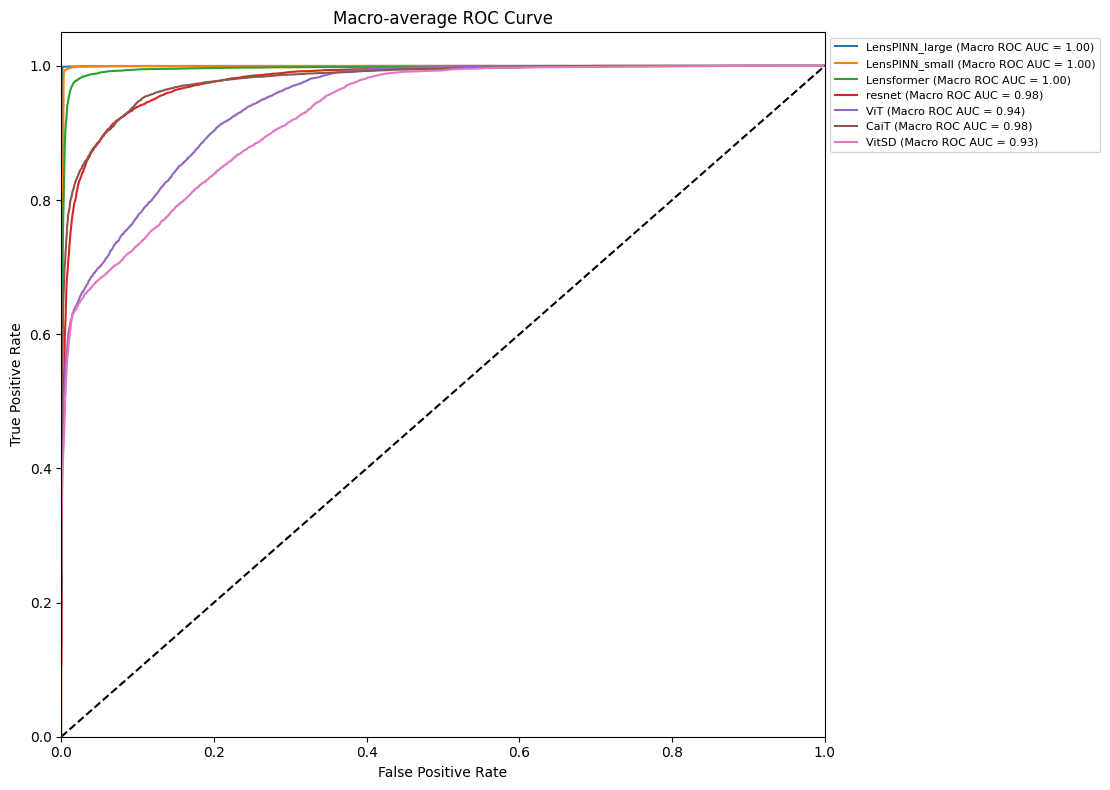

In [98]:
tester_together([model_large,model_small,lens,resnet,ViTr,cait,vitsd], ["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"],test_looader,"cuda","macro")

100%|██████████| 188/188 [00:17<00:00, 10.77it/s]


Accuracy for LensPINN_large: 0.9982501458211815


100%|██████████| 188/188 [00:15<00:00, 12.05it/s]


Accuracy for LensPINN_small: 0.9933338888425964


100%|██████████| 188/188 [00:12<00:00, 14.61it/s]


Accuracy for Lensformer: 0.973835513707191


100%|██████████| 188/188 [00:03<00:00, 53.14it/s]


Accuracy for resnet: 0.9095908674277143


100%|██████████| 188/188 [00:03<00:00, 62.20it/s]


Accuracy for ViT: 0.9079243396383635


100%|██████████| 188/188 [00:03<00:00, 49.62it/s]


Accuracy for CaiT: 0.9510874093825514


100%|██████████| 188/188 [00:02<00:00, 64.41it/s]


Accuracy for VitSD: 0.9097575202066495


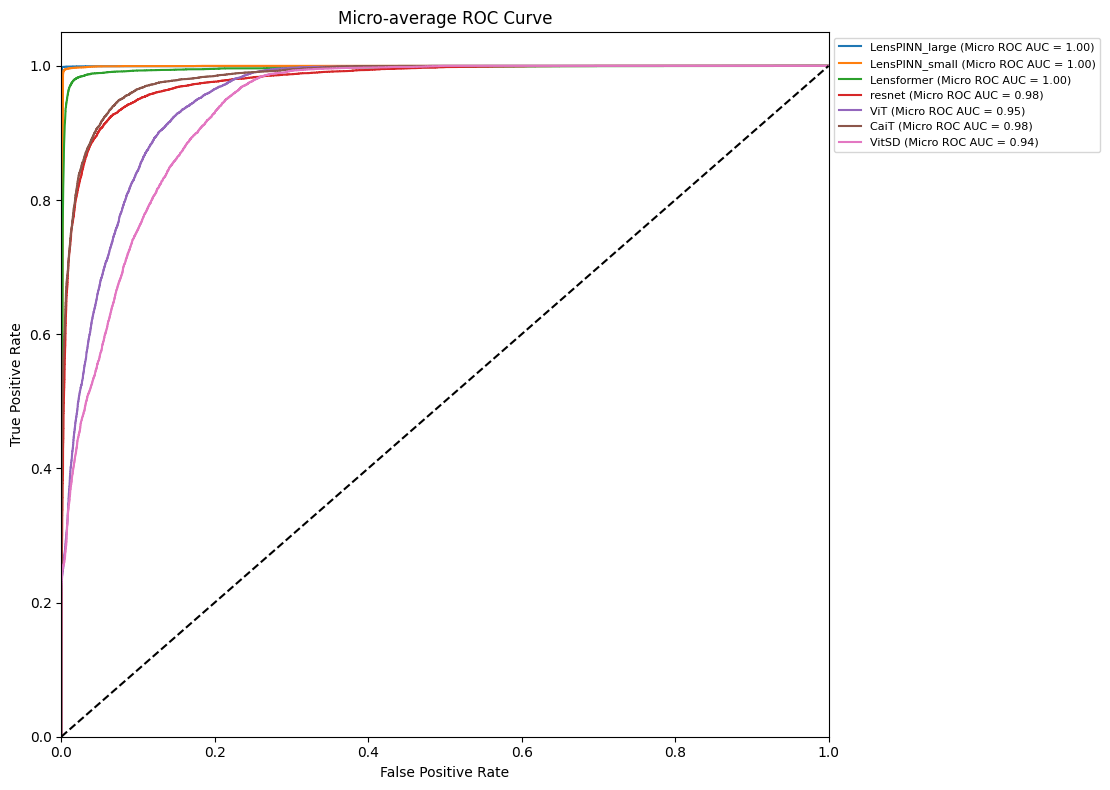

In [99]:
tester_together([model_large,model_small,lens,resnet,ViTr,cait,vitsd], ["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"],test_looader,"cuda","micro")

In [100]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    #print(table)
    #print(f"Total Trainable Params: {total_params}")
    return total_params
def param_report(modellist,namelist):
    for i in range(len(modellist)):
        print("model:",namelist[i],",parameters:",count_parameters(modellist[i]))


In [101]:
param_report([model_large,model_small,lens,resnet,ViTr,cait,vitsd], ["LensPINN_large","LensPINN_small","Lensformer","resnet","ViT","CaiT","VitSD"])

model: LensPINN_large ,parameters: 14563726
model: LensPINN_small ,parameters: 7173654
model: Lensformer ,parameters: 15795013
model: resnet ,parameters: 11171779
model: ViT ,parameters: 13725731
model: CaiT ,parameters: 13767219
model: VitSD ,parameters: 13731877
